Let's test how aligned is our proposed feature on the basis of the neurons

A follow up from `20250528_accentuation_feature_distribution.ipynb` 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import yaml
import glob
import timm
import torch
import torch as th
import torch.nn as nn
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from horama import maco, plot_maco
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms as T
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from circuit_toolkit.CNN_scorers import TorchScorer
from circuit_toolkit.GAN_utils import upconvGAN, Caffenet
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset

In [3]:
from neural_regress.regress_lib import sweep_regressors, perform_regression_sweeplayer_RidgeCV, perform_regression_sweeplayer, record_features
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch, LinearLayer_from_sklearn
from core.data_utils import load_neural_data, load_from_hdf5, load_neural_trial_resp_tensor, create_response_tensor, parse_image_fullpaths
from core.model_load_utils import load_model_transform

### Set up paths for data loading

In [4]:
import yaml
import glob

In [5]:
config_root = r"/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs"
subject_id = "red_20250428-20250430"
config_dir = join(config_root, subject_id)
config_files = sorted(glob.glob(join(config_dir, "*.yaml")))

config_files

['/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch0_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch15_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch2_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch9_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-2025043

In [6]:
chan_pattern = "_Ch19_"
config_pre_chan = [f for f in config_files if chan_pattern in f]
config_pre_chan;

### Demo loading

In [7]:
acc_config = yaml.safe_load(open(config_pre_chan[0]))
xtransform_path = acc_config['xtransform_path']
meta_path = acc_config['meta_path']
readout_path = acc_config['readout_path']
model_name = acc_config['model_name']
unit_ids = acc_config['unit_ids']
layer_name = acc_config['layer_name']
regressor = acc_config['fit_method_name']

In [8]:
def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None


device = "cuda"
model, transforms_pipeline = load_model_transform(model_name, device=device)
model = model.eval().to(device)
model.requires_grad_(False)
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
fetcher.record(layer_name, ingraph=True, store_device=device)
# Load readout layer
readout = th.load(readout_path).to(device)
Xtransform = th.load(xtransform_path).to(device)
# Load PCA transform

def predict_population_response(images):
    """Predict neural population responses for input images.
    
    Args:
        images (torch.Tensor): Input images of shape (batch_size, 3, 224, 224)
        
    Returns:
        torch.Tensor: Predicted neural responses
    """
    model(images)
    feat_tsr = fetcher[layer_name]
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)

check_gradient(predict_population_response)

/n/home12/binxuwang/Github/Closed-loop-visual-insilico/core/brainscore_model_utils.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(local_wei

torch.Size([1, 64])


In [9]:
acc_config

{'model_name': 'AlexNet_training_seed_01',
 'fit_method_name': 'RidgeCV',
 'unit_ids': [19],
 'subject_id': 'red_20250428-20250430',
 'layer_name': '.features.MaxPool2d12',
 'outputdir': '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430',
 'readout_path': '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_readout_.features.MaxPool2d12_pca750_RidgeCV.pth',
 'xtransform_path': '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_Xtfmer_.features.MaxPool2d12_pca750_RidgeCV_JITscript.pt',
 'meta_path': '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_meta_.features.MaxPool2d12_pca750_RidgeCV.pkl',
 'result_folder': '/n/holylabs/LABS/alvarez_lab/Ev

### Loading at scale

In [13]:
def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None


def get_predictor_from_config(acc_config, device="cuda"):
    """Create a function that predicts neural population responses for images.
    
    Args:
        subject_id (str): ID of the subject
        modelname (str): Name of the model to use (e.g. "resnet50_robust") 
        layer_name (str): Name of layer to extract features from
        device (str): Device to run model on ("cuda" or "cpu")
        
    Returns:
        function: A function that takes images as input and returns predicted population responses
    """
    if isinstance(acc_config, str):
        acc_config = yaml.safe_load(open(acc_config))
        
    # Construct paths
    xtransform_path = acc_config['xtransform_path']
    meta_path = acc_config['meta_path']
    readout_path = acc_config['readout_path']
    model_name = acc_config['model_name']
    unit_ids = acc_config['unit_ids']
    layer_name = acc_config['layer_name']
    regressor = acc_config['fit_method_name']
    print(f"Loading model and set up feature extraction: model {model_name}, layer {layer_name}")
    print(f"Target unit ids: {unit_ids}")
    print(f"Loading readout layer and PCA transform: readout {readout_path}, xtransform             {xtransform_path}")
    # Load model and set up feature extraction
    model, transforms_pipeline = load_model_transform(model_name, device=device)
    model = model.eval().to(device)
    model.requires_grad_(False)
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    fetcher.record(layer_name, ingraph=True, store_device=device)
    # Load readout layer and PCA transform
    readout = th.load(readout_path).to(device)
    Xtransform = th.load(xtransform_path).to(device)
    def predict_population_response(images):
        """Predict neural population responses for input images.
        
        Args:
            images (torch.Tensor): Input images of shape (batch_size, 3, 224, 224)
            
        Returns:
            torch.Tensor: Predicted neural responses
        """
        model(images)
        feat_tsr = fetcher[layer_name]
        feat_vec = Xtransform(feat_tsr)
        return readout(feat_vec)
    
    
    def predict_target_unit_response(images):
        """Predict neural population responses for input images.
        
        Args:
            images (torch.Tensor): Input images of shape (batch_size, 3, 224, 224)
            
        Returns:
            torch.Tensor: Predicted neural responses
        """
        model(images)
        feat_tsr = fetcher[layer_name]
        feat_vec = Xtransform(feat_tsr)
        return readout(feat_vec)[:, unit_ids]

    check_gradient(predict_population_response)
    print("Gradient check passed!")
    return predict_population_response, predict_target_unit_response, \
           model, transforms_pipeline, fetcher, Xtransform, readout
           

def get_PCA_basis_predictor_from_config(acc_config, device="cuda"):
    """Create a function that predicts neural population responses for images.
    
    Args:
        subject_id (str): ID of the subject
        modelname (str): Name of the model to use (e.g. "resnet50_robust") 
        layer_name (str): Name of layer to extract features from
        device (str): Device to run model on ("cuda" or "cpu")
        
    Returns:
        function: A function that takes images as input and returns predicted population responses
    """
    if isinstance(acc_config, str):
        acc_config = yaml.safe_load(open(acc_config))
        
    # Construct paths
    xtransform_path = acc_config['xtransform_path']
    meta_path = acc_config['meta_path']
    readout_path = acc_config['readout_path']
    model_name = acc_config['model_name']
    unit_ids = acc_config['unit_ids']
    layer_name = acc_config['layer_name']
    regressor = acc_config['fit_method_name']
    print(f"Loading model and set up feature extraction: model {model_name}, layer {layer_name}")
    print(f"Target unit ids: {unit_ids}")
    print(f"Loading readout layer and PCA transform: readout {readout_path}, xtransform             {xtransform_path}")
    # Load model and set up feature extraction
    model, transforms_pipeline = load_model_transform(model_name, device=device)
    model = model.eval().to(device)
    model.requires_grad_(False)
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    fetcher.record(layer_name, ingraph=True, store_device=device)
    # Load readout layer and PCA transform
    readout = th.load(readout_path).to(device)
    Xtransform = th.load(xtransform_path).to(device)
    def predict_reduced_feature(images):
        """Predict neural population responses for input images.
        
        Args:
            images (torch.Tensor): Input images of shape (batch_size, 3, 224, 224)
            
        Returns:
            torch.Tensor: Predicted neural responses
        """
        model(images)
        feat_tsr = fetcher[layer_name]
        feat_vec = Xtransform(feat_tsr)
        return feat_vec
    
    check_gradient(predict_reduced_feature)
    print("Gradient check passed!")
    return predict_reduced_feature, \
           model, transforms_pipeline, fetcher, Xtransform, readout

In [11]:
config_root = r"/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs"
subject_id = "red_20250428-20250430"
config_dir = join(config_root, subject_id)
config_files = sorted(glob.glob(join(config_dir, "*.yaml")))
chan_pattern = "_Ch19_"
config_pre_chan = [f for f in config_files if chan_pattern in f]

Check that all predictors can be loaded! 

In [12]:
config_root = r"/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs"
subject_id = "red_20250428-20250430"
config_dir = join(config_root, subject_id)
config_files = sorted(glob.glob(join(config_dir, "*.yaml")))
chan_pattern = "_Ch19_"
config_pre_chan = [f for f in config_files if chan_pattern in f]
for config_file in config_pre_chan:
    predict_reduced_feature, \
        model, transforms_pipeline, fetcher, Xtransform, readout \
            = get_PCA_basis_predictor_from_config(config_file, device="cuda")
    # print(population_predictor)
    # print(target_unit_predictor)

Loading model and set up feature extraction: model AlexNet_training_seed_01, layer .features.MaxPool2d12
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_readout_.features.MaxPool2d12_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_Xtfmer_.features.MaxPool2d12_pca750_RidgeCV_JITscript.pt


/tmp/ipykernel_66419/1599505506.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  readout = th.load(readout_path).to(device)
/tmp/ipykernel_66419/1599505506.py:115: Futu

torch.Size([1, 750])
Gradient check passed!
Loading model and set up feature extraction: model clipag_vitb32, layer .transformer.resblocks.ResidualAttentionBlock9
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_clipag_vitb32_Ch19_readout_.transformer.resblocks.ResidualAttentionBlock9_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_clipag_vitb32_Ch19_Xtfmer_.transformer.resblocks.ResidualAttentionBlock9_pca750_RidgeCV_JITscript.pt


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/n/home12/binxuwang/Github/Closed-loop-visual-insilico/core/model_load_utils.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend 

torch.Size([1, 750])
Gradient check passed!
Loading model and set up feature extraction: model dinov2_vitb14_reg, layer .blocks.NestedTensorBlock11
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_dinov2_vitb14_reg_Ch19_readout_.blocks.NestedTensorBlock11_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_dinov2_vitb14_reg_Ch19_Xtfmer_.blocks.NestedTensorBlock11_pca750_RidgeCV_JITscript.pt


Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/swiglu_op.py:128: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Ple

torch.Size([1, 750])
Gradient check passed!
Loading model and set up feature extraction: model radio_v2.5-b, layer .model.blocks.Block10
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_radio_v2.5-b_Ch19_readout_.model.blocks.Block10_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_radio_v2.5-b_Ch19_Xtfmer_.model.blocks.Block10_pca750_RidgeCV_JITscript.pt


Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/NVlabs_RADIO_main


torch.Size([1, 750])
Gradient check passed!
Loading model and set up feature extraction: model regnety_640, layer .s4.Bottleneckb1
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_regnety_640_Ch19_readout_.s4.Bottleneckb1_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_regnety_640_Ch19_Xtfmer_.s4.Bottleneckb1_pca750_RidgeCV_JITscript.pt
torch.Size([1, 750])
Gradient check passed!
Loading model and set up feature extraction: model resnet50, layer .layer4.Bottleneck0
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_Ch19_readout_.layer4.Bottleneck0_pca750_RidgeCV.pth, xtransform          

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 750])
Gradient check passed!
Loading model and set up feature extraction: model resnet50_clip, layer .layer4.Bottleneck1
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_clip_Ch19_readout_.layer4.Bottleneck1_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_clip_Ch19_Xtfmer_.layer4.Bottleneck1_pca750_RidgeCV_JITscript.pt
torch.Size([1, 750])
Gradient check passed!
Loading model and set up feature extraction: model resnet50_dino, layer .layer4.Bottleneck1
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_dino_Ch19_readout_.layer4.Bottleneck1_pca750_RidgeCV.

Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dino_main
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([1, 750])
Gradient check passed!
Loading model and set up feature extraction: model resnet50_robust, layer .layer4.Bottleneck2
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_robust_Ch19_readout_.layer4.Bottleneck2_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_robust_Ch19_Xtfmer_.layer4.Bottleneck2_pca750_RidgeCV_JITscript.pt


/n/home12/binxuwang/Github/Closed-loop-visual-insilico/core/model_load_utils.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load("/n/holylfs06

torch.Size([1, 750])
Gradient check passed!
Loading model and set up feature extraction: model siglip2_vitb16, layer .trunk.blocks.Block9
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_siglip2_vitb16_Ch19_readout_.trunk.blocks.Block9_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_siglip2_vitb16_Ch19_Xtfmer_.trunk.blocks.Block9_pca750_RidgeCV_JITscript.pt
torch.Size([1, 750])
Gradient check passed!


In [15]:
acc_stim_root = r"/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_outputs"
target_subfolder = glob.glob(join(acc_stim_root, f"*{subject_id}*_accentuation"))
target_subfolder

['/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_outputs/02-05-2025_red_20250428-20250430_AlexNet_training_seed_01_accentuation',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_outputs/02-05-2025_red_20250428-20250430_clipag_vitb32_accentuation',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_outputs/02-05-2025_red_20250428-20250430_dinov2_vitb14_reg_accentuation',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_outputs/02-05-2025_red_20250428-20250430_radio_v2.5-b_accentuation',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_outputs/02-05-2025_red_20250428-20250430_regnety_640_accentuation',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_outputs/02-05-2025_red_20250428-20250430_resnet50_accentuation',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_outputs/02-05-2025_red_20250428-20250430_resnet50_clip_accentuation',
 '/n/holylabs/LABS/alvarez_

In [16]:
# List all png files in each subfolder (one level deep)
all_png_files = {}
for subfolder in target_subfolder:
    subfolder_name = os.path.basename(subfolder)
    png_files = glob.glob(join(subfolder, "*.png"))
    # Sort the files to ensure consistent order
    png_files.sort()
    all_png_files[subfolder_name] = png_files
    print(f"Found {len(png_files)} PNG files in {subfolder_name}")
    # Print first few files as example
    for file in png_files[:5]:
        print(f"  - {os.path.basename(file)}")
    if len(png_files) > 5:
        print(f"  - ... and {len(png_files)-5} more files")
    print()

Found 550 PNG files in 02-05-2025_red_20250428-20250430_AlexNet_training_seed_01_accentuation
  - AlexNet_training_seed_01_RidgeCV_unit_0_img_0_level_-0.2282366166114813_score_-0.22128941118717194.png
  - AlexNet_training_seed_01_RidgeCV_unit_0_img_0_level_-1.0373457669019694_score_-1.0278555154800415.png
  - AlexNet_training_seed_01_RidgeCV_unit_0_img_0_level_-1.8464549171924576_score_-1.8385322093963623.png
  - AlexNet_training_seed_01_RidgeCV_unit_0_img_0_level_0.580872533679007_score_0.5721354484558105.png
  - AlexNet_training_seed_01_RidgeCV_unit_0_img_0_level_1.389981683969495_score_1.380919098854065.png
  - ... and 545 more files

Found 550 PNG files in 02-05-2025_red_20250428-20250430_clipag_vitb32_accentuation
  - clipag_vitb32_RidgeCV_unit_0_img_0_level_-0.2282366166114813_score_-0.2212853878736496.png
  - clipag_vitb32_RidgeCV_unit_0_img_0_level_-1.0373457669019694_score_-1.0278148651123047.png
  - clipag_vitb32_RidgeCV_unit_0_img_0_level_-1.8464549171924576_score_-1.8379993

In [ ]:
import re

def parse_accentuated_filename(filename):
    """
    Parse accentuated image filenames to extract metadata.
    
    Example filename format:
    radio_v2.5-b_RidgeCV_unit_0_img_0_level_0.580872533679007_score_0.5726814270019531.png
    
    Returns:
        dict: Dictionary containing extracted metadata (model_name, unit_id, img_id, level, score)
    """
    # Get just the filename without path
    basename = os.path.basename(filename)
    # Extract components using regex
    pattern = r'(.+?)_RidgeCV_unit_(\d+)_img_(\d+)_level_([-\d\.]+)_score_([-\d\.]+)\.png'
    match = re.search(pattern, basename)
    if match:
        model_name, unit_id, img_id, level, score = match.groups()
        return {
            'model_name': model_name,
            'unit_id': int(unit_id),
            'img_id': int(img_id),
            'level': float(level),
            'score': float(score),
            'filepath': filename
        }
    else:
        return None

def parse_accentuated_filenames_to_df(filenames):
    """
    Parse a list of accentuated image filenames and return as a DataFrame.
    
    Args:
        filenames (list): List of filenames to parse
        
    Returns:
        pd.DataFrame: DataFrame containing parsed metadata for all files
    """
    import pandas as pd
    parsed_data = []
    for filename in filenames:
        parsed = parse_accentuated_filename(filename)
        if parsed:
            parsed_data.append(parsed)
    
    if parsed_data:
        return pd.DataFrame(parsed_data)
    else:
        return pd.DataFrame()


In [18]:
# Test the function on the file list
import re
import pandas as pd
# Parse all files into a DataFrame
png_files_list = sum(all_png_files.values(), [])
df_accentuated = parse_accentuated_filenames_to_df(png_files_list)
# Display info about the DataFrame
print(f"DataFrame shape: {df_accentuated.shape}")
print("\nDataFrame columns:")
print(df_accentuated.columns.tolist())

# Display first few rows
print("\nFirst few rows:")
display(df_accentuated.head())

# Show unique models and units
print(f"\nUnique models: {df_accentuated['model_name'].nunique()}")
print(f"Unique units: {df_accentuated['unit_id'].nunique()}")
print(f"Unique image IDs: {df_accentuated['img_id'].nunique()}")
print(f"Unique levels: {df_accentuated['level'].nunique()}")
print(f"Unique scores: {df_accentuated['score'].nunique()}")

DataFrame shape: (5500, 6)

DataFrame columns:
['model_name', 'unit_id', 'img_id', 'level', 'score', 'filepath']

First few rows:


model_name  unit_id  img_id     level     score  \
0  AlexNet_training_seed_01        0       0 -0.228237 -0.221289   
1  AlexNet_training_seed_01        0       0 -1.037346 -1.027856   
2  AlexNet_training_seed_01        0       0 -1.846455 -1.838532   
3  AlexNet_training_seed_01        0       0  0.580873  0.572135   
4  AlexNet_training_seed_01        0       0  1.389982  1.380919   

                                            filepath  
0  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...  
1  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...  
2  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...  
3  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...  
4  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...


Unique models: 10
Unique units: 5
Unique image IDs: 10
Unique levels: 55
Unique scores: 5489


In [19]:
from circuit_toolkit.dataset_utils import ImagePathDataset, DataLoader
def get_prediction_responses(pred_fn, transforms_pipeline, image_fps, device="cuda", batch_size=100, num_workers=16):
    """
    Get the prediction responses for a set of images
    """
    dataset = ImagePathDataset(image_fps, transform=transforms_pipeline)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    pred_resp = []
    for batch in tqdm(dataloader):
        batch_img = batch[0].to(device)
        with th.no_grad():
            batch_resp = pred_fn(batch_img).cpu()
        pred_resp.append(batch_resp)
    return torch.cat(pred_resp, dim=0)

In [20]:
config_pre_chan

['/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_clipag_vitb32_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_dinov2_vitb14_reg_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_radio_v2.5-b_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_regnety_640_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_resnet50_Ch19_accentuation_config.yaml

In [21]:
config_root = r"/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs"
subject_id = "red_20250428-20250430"
config_dir = join(config_root, subject_id)
config_files = sorted(glob.glob(join(config_dir, "*.yaml")))
chan_pattern = "_Ch19_"
config_pre_chan = [f for f in config_files if chan_pattern in f]
config_file = config_pre_chan[0]
# for config_file in config_pre_chan:
population_predictor, target_unit_predictor, \
    model, transforms_pipeline, _, _, _ \
        = get_predictor_from_config(config_file, device="cuda")

accentuated_dataset = ImagePathDataset(df_accentuated["filepath"], transform=transforms_pipeline)
accentuated_dataloader = DataLoader(accentuated_dataset, batch_size=100, shuffle=False, num_workers=10)

acc_img_pop_resp = get_prediction_responses(population_predictor, transforms_pipeline, 
                                        df_accentuated["filepath"])

Loading model and set up feature extraction: model AlexNet_training_seed_01, layer .features.MaxPool2d12
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_readout_.features.MaxPool2d12_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_Xtfmer_.features.MaxPool2d12_pca750_RidgeCV_JITscript.pt


/n/home12/binxuwang/Github/Closed-loop-visual-insilico/core/brainscore_model_utils.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(local_wei

torch.Size([1, 64])
Gradient check passed!
The (227, 227) setting is overwritten by the size in custom transform
The (227, 227) setting is overwritten by the size in custom transform


/tmp/ipykernel_66419/1599505506.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  readout = th.load(readout_path).to(device)
/tmp/ipykernel_66419/1599505506.py:45: Future

  0%|          | 0/55 [00:00<?, ?it/s]

In [23]:
config_root = r"/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs"
subject_id = "red_20250428-20250430"
config_dir = join(config_root, subject_id)
config_files = sorted(glob.glob(join(config_dir, "*.yaml")))
chan_pattern = "_Ch19_"
config_pre_chan = [f for f in config_files if chan_pattern in f]
config_file = config_pre_chan[1]
# for config_file in config_pre_chan:
population_predictor, target_unit_predictor, \
    model, transforms_pipeline, _, _, _ \
        = get_predictor_from_config(config_file, device="cuda")

accentuated_dataset = ImagePathDataset(df_accentuated["filepath"], transform=transforms_pipeline)
accentuated_dataloader = DataLoader(accentuated_dataset, batch_size=100, shuffle=False, num_workers=10)

acc_img_pop_resp = get_prediction_responses(population_predictor, transforms_pipeline, 
                                        df_accentuated["filepath"])

Loading model and set up feature extraction: model clipag_vitb32, layer .transformer.resblocks.ResidualAttentionBlock9
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_clipag_vitb32_Ch19_readout_.transformer.resblocks.ResidualAttentionBlock9_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_clipag_vitb32_Ch19_Xtfmer_.transformer.resblocks.ResidualAttentionBlock9_pca750_RidgeCV_JITscript.pt


/n/home12/binxuwang/Github/Closed-loop-visual-insilico/core/model_load_utils.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(join(ckpt_dir, 'CLIPAG_Vi

torch.Size([1, 64])
Gradient check passed!
The (227, 227) setting is overwritten by the size in custom transform
The (227, 227) setting is overwritten by the size in custom transform


/tmp/ipykernel_66419/1599505506.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  readout = th.load(readout_path).to(device)
/tmp/ipykernel_66419/1599505506.py:45: Future

  0%|          | 0/55 [00:00<?, ?it/s]

In [24]:
acc_img_pop_resp.shape

torch.Size([5500, 64])

In [22]:
config_pre_chan

['/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_clipag_vitb32_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_dinov2_vitb14_reg_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_radio_v2.5-b_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_regnety_640_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_resnet50_Ch19_accentuation_config.yaml

### Predict PCA feature and measure the alignment with the neuron readouts

In [72]:
config_pre_chan

['/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_clipag_vitb32_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_dinov2_vitb14_reg_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_radio_v2.5-b_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_regnety_640_Ch19_accentuation_config.yaml',
 '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs/red_20250428-20250430/red_20250428-20250430_resnet50_Ch19_accentuation_config.yaml

In [82]:
config_root = r"/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs"
subject_id = "red_20250428-20250430"
config_dir = join(config_root, subject_id)
config_files = sorted(glob.glob(join(config_dir, "*.yaml")))
chan_pattern = "_Ch19_"
config_pre_chan = [f for f in config_files if chan_pattern in f]
config_file = config_pre_chan[0]
# for config_file in config_pre_chan:
config_acc = yaml.load(open(config_file, "r"), Loader=yaml.FullLoader)

predict_PCA_feature, \
    model, transforms_pipeline, fetcher, Xtransform, readout \
        = get_PCA_basis_predictor_from_config(config_file, device="cuda")

accentuated_dataset = ImagePathDataset(df_accentuated["filepath"], transform=transforms_pipeline)
accentuated_dataloader = DataLoader(accentuated_dataset, batch_size=100, shuffle=False, num_workers=10)
acc_img_PCA_resp = get_prediction_responses(predict_PCA_feature, transforms_pipeline, 
                                        df_accentuated["filepath"])

Loading model and set up feature extraction: model AlexNet_training_seed_01, layer .features.MaxPool2d12
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_readout_.features.MaxPool2d12_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_Xtfmer_.features.MaxPool2d12_pca750_RidgeCV_JITscript.pt


/n/home12/binxuwang/Github/Closed-loop-visual-insilico/core/brainscore_model_utils.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(local_wei

torch.Size([1, 750])
Gradient check passed!
The (227, 227) setting is overwritten by the size in custom transform
The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/55 [00:00<?, ?it/s]

In [83]:
config_acc

{'model_name': 'AlexNet_training_seed_01',
 'fit_method_name': 'RidgeCV',
 'unit_ids': [19],
 'subject_id': 'red_20250428-20250430',
 'layer_name': '.features.MaxPool2d12',
 'outputdir': '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430',
 'readout_path': '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_readout_.features.MaxPool2d12_pca750_RidgeCV.pth',
 'xtransform_path': '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_Xtfmer_.features.MaxPool2d12_pca750_RidgeCV_JITscript.pt',
 'meta_path': '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_meta_.features.MaxPool2d12_pca750_RidgeCV.pkl',
 'result_folder': '/n/holylabs/LABS/alvarez_lab/Ev

In [84]:
model_name = config_acc["model_name"]
unit_id = config_acc["unit_ids"][0]
layer_name = config_acc["layer_name"]
acc_split_df = df_accentuated.query("model_name == @model_name and unit_id == @unit_id")

In [85]:
readout_vec = readout.weight.data[unit_id, :].cpu()
readout_bias = readout.bias.data[unit_id].cpu()

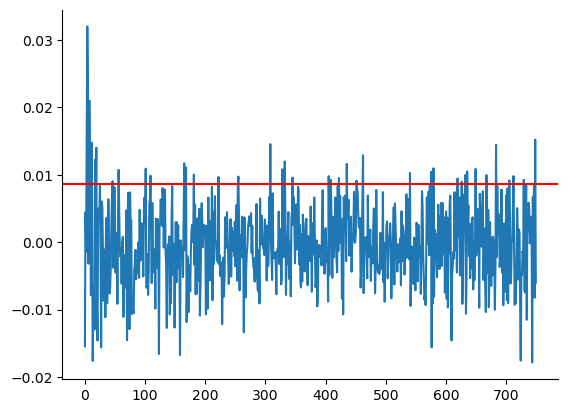

In [76]:
plt.plot(readout_vec)
plt.axhline(readout_bias, color="red")
plt.show()

In [86]:
acc_model_unit_PCA_resp = acc_img_PCA_resp[acc_split_df.index, :]

In [78]:
acc_model_unit_PCA_resp.shape

torch.Size([110, 750])

In [79]:
acc_split_df

model_name  unit_id  img_id     level     score  \
2970   resnet50       19       0 -0.259917 -0.250845   
2971   resnet50       19       0 -1.071168 -1.061648   
2972   resnet50       19       0 -1.882419 -1.873383   
2973   resnet50       19       0  0.551334  0.542542   
2974   resnet50       19       0  1.362585  1.354161   
...         ...      ...     ...       ...       ...   
3075   resnet50       19       9  2.985086  2.977895   
3076   resnet50       19       9  3.796337  3.786527   
3077   resnet50       19       9  4.607588  4.598561   
3078   resnet50       19       9  5.418838  5.412777   
3079   resnet50       19       9  6.230089  6.220412   

                                               filepath  
2970  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...  
2971  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...  
2972  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...  
2973  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...  
2974  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...  
...                                                 ...  
3075  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...  
3076  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...  
3077  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...  
3078  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...  
3079  /n/holylabs/LABS/alvarez_lab/Everyone/Accentua...  

[110 rows x 6 columns]

Cosine similarities shape: (110,)
Mean cosine similarity: 0.0709
Std cosine similarity: 0.0909
Min cosine similarity: -0.1277
Max cosine similarity: 0.1913


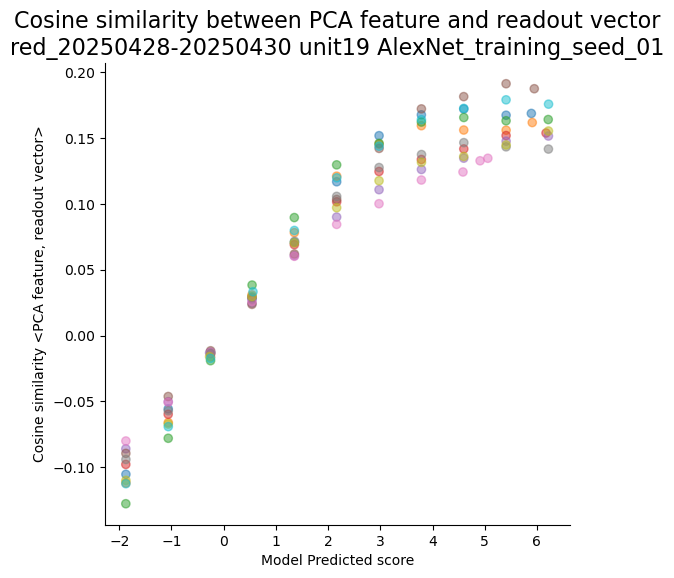

In [87]:
# Calculate cosine similarity between PCA responses and readout vector
from sklearn.metrics.pairwise import cosine_similarity
# Compute cosine similarity between each PCA response and the readout vector
cosine_sims = cosine_similarity(acc_model_unit_PCA_resp, readout_vec.numpy().reshape(1, -1))
cosine_sims = cosine_sims.flatten()
print(f"Cosine similarities shape: {cosine_sims.shape}")
print(f"Mean cosine similarity: {cosine_sims.mean():.4f}")
print(f"Std cosine similarity: {cosine_sims.std():.4f}")
print(f"Min cosine similarity: {cosine_sims.min():.4f}")
print(f"Max cosine similarity: {cosine_sims.max():.4f}")

plt.figure(figsize=(6, 6))
plt.scatter(acc_split_df.score, cosine_sims, c=acc_split_df.img_id, cmap="tab10", alpha=0.5)
plt.ylabel("Cosine similarity <PCA feature, readout vector>", fontsize=10)
plt.xlabel("Model Predicted score", fontsize=10)
plt.title(f"Cosine similarity between PCA feature and readout vector\n{subject_id} unit{unit_id} {model_name}", fontsize=16)
plt.show()

In [80]:
# Calculate cosine similarity between PCA responses and readout vector
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between each PCA response and the readout vector
cosine_sims = cosine_similarity(acc_model_unit_PCA_resp, readout_vec.numpy().reshape(1, -1))
cosine_sims = cosine_sims.flatten()

print(f"Cosine similarities shape: {cosine_sims.shape}")
print(f"Mean cosine similarity: {cosine_sims.mean():.4f}")
print(f"Std cosine similarity: {cosine_sims.std():.4f}")
print(f"Min cosine similarity: {cosine_sims.min():.4f}")
print(f"Max cosine similarity: {cosine_sims.max():.4f}")


Cosine similarities shape: (110,)
Mean cosine similarity: 0.1947
Std cosine similarity: 0.2404
Min cosine similarity: -0.2603
Max cosine similarity: 0.4811


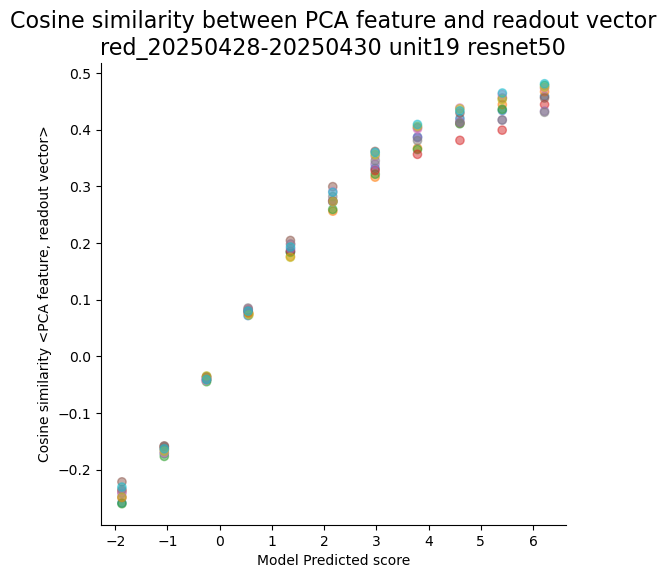

In [81]:
plt.figure(figsize=(6, 6))
plt.scatter(acc_split_df.score, cosine_sims, c=acc_split_df.img_id, cmap="tab10", alpha=0.5)
plt.ylabel("Cosine similarity <PCA feature, readout vector>", fontsize=10)
plt.xlabel("Model Predicted score", fontsize=10)
plt.title(f"Cosine similarity between PCA feature and readout vector\n{subject_id} unit{unit_id} {model_name}", fontsize=16)
plt.show()

In [69]:
# Calculate cosine similarity between PCA responses and readout vector
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between each PCA response and the readout vector
cosine_sims = cosine_similarity(acc_model_unit_PCA_resp, readout_vec.numpy().reshape(1, -1))
cosine_sims = cosine_sims.flatten()

print(f"Cosine similarities shape: {cosine_sims.shape}")
print(f"Mean cosine similarity: {cosine_sims.mean():.4f}")
print(f"Std cosine similarity: {cosine_sims.std():.4f}")
print(f"Min cosine similarity: {cosine_sims.min():.4f}")
print(f"Max cosine similarity: {cosine_sims.max():.4f}")


Cosine similarities shape: (110,)
Mean cosine similarity: 0.1436
Std cosine similarity: 0.1705
Min cosine similarity: -0.1732
Max cosine similarity: 0.3485


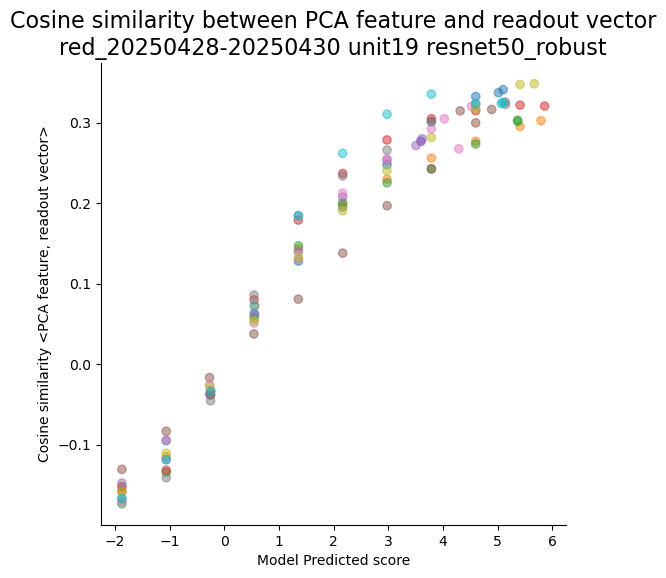

In [70]:
plt.figure(figsize=(6, 6))
plt.scatter(acc_split_df.score, cosine_sims, c=acc_split_df.img_id, cmap="tab10", alpha=0.5)
plt.ylabel("Cosine similarity <PCA feature, readout vector>", fontsize=10)
plt.xlabel("Model Predicted score", fontsize=10)
plt.title(f"Cosine similarity between PCA feature and readout vector\n{subject_id} unit{unit_id} {model_name}", fontsize=16)
plt.show()

In [48]:
# Calculate cosine similarity between PCA responses and readout vector
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between each PCA response and the readout vector
cosine_sims = cosine_similarity(acc_model_unit_PCA_resp, readout_vec.numpy().reshape(1, -1))
cosine_sims = cosine_sims.flatten()

print(f"Cosine similarities shape: {cosine_sims.shape}")
print(f"Mean cosine similarity: {cosine_sims.mean():.4f}")
print(f"Std cosine similarity: {cosine_sims.std():.4f}")
print(f"Min cosine similarity: {cosine_sims.min():.4f}")
print(f"Max cosine similarity: {cosine_sims.max():.4f}")


Cosine similarities shape: (110,)
Mean cosine similarity: 0.1605
Std cosine similarity: 0.2136
Min cosine similarity: -0.3023
Max cosine similarity: 0.3699


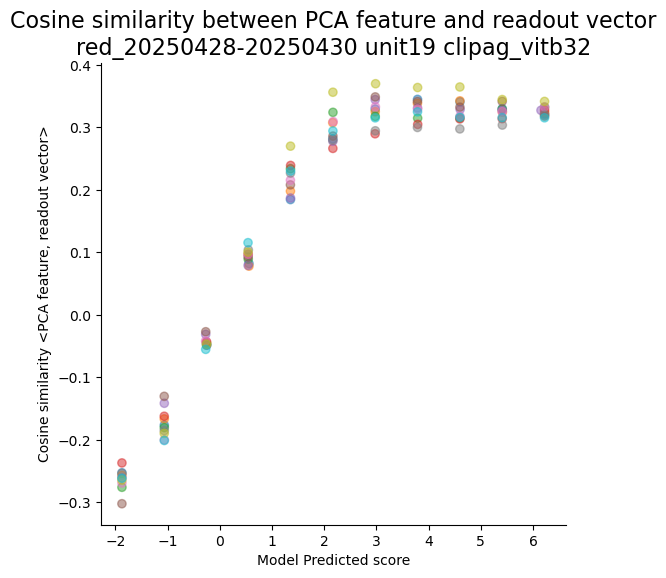

In [60]:
plt.figure(figsize=(6, 6))
plt.scatter(acc_split_df.score, cosine_sims, c=acc_split_df.img_id, cmap="tab10", alpha=0.5)
plt.ylabel("Cosine similarity <PCA feature, readout vector>", fontsize=10)
plt.xlabel("Model Predicted score", fontsize=10)
plt.title(f"Cosine similarity between PCA feature and readout vector\n{subject_id} unit{unit_id} {model_name}", fontsize=16)
plt.show()

In [40]:
print(readout_vec, readout_bias)

tensor([-2.4131e-02, -2.4893e-02, -2.0526e-02,  2.5647e-02,  2.3444e-02,
         9.1146e-03, -7.2221e-03,  2.9663e-04,  1.3069e-02,  6.3575e-03,
         7.1264e-03, -4.6679e-03, -4.9329e-04, -7.9258e-04,  1.5489e-03,
        -2.5445e-04, -2.8085e-03, -3.9015e-03,  5.1361e-03,  1.1107e-03,
         4.4515e-03,  1.7863e-03, -7.5782e-03, -1.8315e-02,  2.4788e-03,
         4.4195e-03,  5.1360e-03,  6.9877e-04, -5.8833e-03, -4.5272e-03,
         3.4279e-03,  4.7390e-03,  1.6244e-04,  6.3808e-03, -1.9018e-03,
        -4.0868e-03, -7.1895e-03,  3.0336e-03,  4.3811e-03, -1.5715e-03,
         3.0592e-03,  3.5439e-03, -4.9794e-03, -4.1292e-03, -8.0222e-03,
         1.6548e-02, -4.4074e-03,  8.2318e-03, -6.0638e-03,  2.8341e-03,
         3.2885e-03, -5.7102e-03,  3.7936e-03,  2.4422e-03,  1.7666e-03,
         2.1336e-03,  2.5706e-03, -1.3637e-03,  1.7035e-03,  7.1595e-03,
        -7.1301e-03, -9.0289e-04, -9.7834e-03,  1.0428e-02,  4.7128e-03,
        -1.3889e-03,  6.1157e-03, -1.2196e-03, -2.6

### All models summary

In [ ]:
config_root = r"/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/accentuation_configs"
subject_id = "red_20250428-20250430"
config_dir = join(config_root, subject_id)
config_files = sorted(glob.glob(join(config_dir, "*.yaml")))
chan_pattern = "_Ch19_"
config_pre_chan = [f for f in config_files if chan_pattern in f]
cosine_results = []
for config_file in config_pre_chan:
    config_acc = yaml.load(open(config_file, "r"), Loader=yaml.FullLoader)
    model_name = config_acc["model_name"]
    unit_id = config_acc["unit_ids"][0]
    layer_name = config_acc["layer_name"]
    print(f"Model: {model_name}, Unit: {unit_id}, Layer: {layer_name}")
    acc_split_df = df_accentuated.query("model_name == @model_name and unit_id == @unit_id")
    assert len (acc_split_df) == 110 

    predict_PCA_feature, \
        model, transforms_pipeline, fetcher, Xtransform, readout \
            = get_PCA_basis_predictor_from_config(config_file, device="cuda")
    # accentuated_dataset = ImagePathDataset(acc_split_df["filepath"], transform=transforms_pipeline)
    # accentuated_dataloader = DataLoader(accentuated_dataset, batch_size=60, shuffle=False, num_workers=10)
    acc_img_PCA_resp = get_prediction_responses(predict_PCA_feature, transforms_pipeline, 
                                        acc_split_df["filepath"].tolist(), batch_size=120, num_workers=16)

    acc_model_unit_PCA_resp = acc_img_PCA_resp.cpu().numpy()
    readout_vec = readout.weight.data[unit_id, :].cpu()
    cosine_sims = cosine_similarity(acc_model_unit_PCA_resp, readout_vec.numpy().reshape(1, -1))
    cosine_sims = cosine_sims.flatten()
    PCA_norm = np.linalg.norm(acc_model_unit_PCA_resp, axis=1)  
    acc_split_df_cos = acc_split_df.copy()
    acc_split_df_cos["cosine_similarity"] = cosine_sims
    acc_split_df_cos["PCA_norm"] = PCA_norm
    # print(f"Cosine similarities shape: {cosine_sims.shape}")
    # print(f"Mean cosine similarity: {cosine_sims.mean():.4f}")
    # print(f"Std cosine similarity: {cosine_sims.std():.4f}")
    print(f"Min cosine similarity: {cosine_sims.min():.4f}")
    print(f"Max cosine similarity: {cosine_sims.max():.4f}")
    print(f"PCA norm max {PCA_norm.max():.4f}")
    print(f"PCA norm min {PCA_norm.min():.4f}")
    cosine_results.append({"config": config_acc, 
                           "df": acc_split_df_cos.copy(), 
                           "PCA_resp": acc_model_unit_PCA_resp.copy(), 
                           "readout_vec": readout_vec.clone(), 
                           "cosine_sims": cosine_sims.copy(), 
                           "PCA_norm": PCA_norm.copy()})


Model: AlexNet_training_seed_01, Unit: 19, Layer: .features.MaxPool2d12
Loading model and set up feature extraction: model AlexNet_training_seed_01, layer .features.MaxPool2d12
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_readout_.features.MaxPool2d12_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_Xtfmer_.features.MaxPool2d12_pca750_RidgeCV_JITscript.pt
torch.Size([1, 750])
Gradient check passed!
The (227, 227) setting is overwritten by the size in custom transform


/n/home12/binxuwang/Github/Closed-loop-visual-insilico/core/brainscore_model_utils.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(local_wei

  0%|          | 0/1 [00:00<?, ?it/s]

Min cosine similarity: -0.1277
Max cosine similarity: 0.1913
PCA norm max 1.8355
PCA norm min 0.5785
Model: clipag_vitb32, Unit: 19, Layer: .transformer.resblocks.ResidualAttentionBlock9


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception ignored in: <function _ConnectionBase.__del__ at 0x152ea81ac280>
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    self._close()
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    reader_close()
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/connection.py", line 177, in close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
    reader_close()
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/

Loading model and set up feature extraction: model clipag_vitb32, layer .transformer.resblocks.ResidualAttentionBlock9
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_clipag_vitb32_Ch19_readout_.transformer.resblocks.ResidualAttentionBlock9_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_clipag_vitb32_Ch19_Xtfmer_.transformer.resblocks.ResidualAttentionBlock9_pca750_RidgeCV_JITscript.pt
torch.Size([1, 750])
Gradient check passed!
The (227, 227) setting is overwritten by the size in custom transform


/tmp/ipykernel_66419/1599505506.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  readout = th.load(readout_path).to(device)
/tmp/ipykernel_66419/1599505506.py:115: Futu

  0%|          | 0/1 [00:00<?, ?it/s]

Min cosine similarity: -0.3023
Max cosine similarity: 0.3699
PCA norm max 122.8993
PCA norm min 28.8687
Model: dinov2_vitb14_reg, Unit: 19, Layer: .blocks.NestedTensorBlock11
Loading model and set up feature extraction: model dinov2_vitb14_reg, layer .blocks.NestedTensorBlock11
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_dinov2_vitb14_reg_Ch19_readout_.blocks.NestedTensorBlock11_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_dinov2_vitb14_reg_Ch19_Xtfmer_.blocks.NestedTensorBlock11_pca750_RidgeCV_JITscript.pt


Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dinov2_main
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/connection.py", line 177, in close
    reader_close()
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/connection.py", line 177, in close
    reader_close()
  File "/n/home12/binxuwang/.conda/envs/tor

torch.Size([1, 750])
Gradient check passed!
The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/1 [00:00<?, ?it/s]

Min cosine similarity: -0.3121
Max cosine similarity: 0.3917
PCA norm max 2939.5837
PCA norm min 781.8829
Model: radio_v2.5-b, Unit: 19, Layer: .model.blocks.Block10
Loading model and set up feature extraction: model radio_v2.5-b, layer .model.blocks.Block10
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_radio_v2.5-b_Ch19_readout_.model.blocks.Block10_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_radio_v2.5-b_Ch19_Xtfmer_.model.blocks.Block10_pca750_RidgeCV_JITscript.pt


Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/NVlabs_RADIO_main
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception ignored in: <function _ConnectionBase.__del__ at 0x152ea81ac280>
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
    reader_close()
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    self._close()
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
    _close(self._h

torch.Size([1, 750])
Gradient check passed!
The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/1 [00:00<?, ?it/s]

Min cosine similarity: -0.3004
Max cosine similarity: 0.4830
PCA norm max 86.6001
PCA norm min 29.9134
Model: regnety_640, Unit: 19, Layer: .s4.Bottleneckb1
Loading model and set up feature extraction: model regnety_640, layer .s4.Bottleneckb1
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_regnety_640_Ch19_readout_.s4.Bottleneckb1_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_regnety_640_Ch19_Xtfmer_.s4.Bottleneckb1_pca750_RidgeCV_JITscript.pt


Exception ignored in: Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
<function _ConnectionBase.__del__ at 0x152ea81ac280>
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
    reader_close()
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    self._close()
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

torch.Size([1, 750])
Gradient check passed!
The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/1 [00:00<?, ?it/s]

Min cosine similarity: -0.2232
Max cosine similarity: 0.4830
PCA norm max 44.4442
PCA norm min 8.4947
Model: resnet50, Unit: 19, Layer: .layer4.Bottleneck0
Loading model and set up feature extraction: model resnet50, layer .layer4.Bottleneck0
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_Ch19_readout_.layer4.Bottleneck0_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_Ch19_Xtfmer_.layer4.Bottleneck0_pca750_RidgeCV_JITscript.pt


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_66419/1599505506.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/p

torch.Size([1, 750])
Gradient check passed!
The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/1 [00:00<?, ?it/s]

Min cosine similarity: -0.2603
Max cosine similarity: 0.4811
PCA norm max 89.4542
PCA norm min 36.0897
Model: resnet50_clip, Unit: 19, Layer: .layer4.Bottleneck1
Loading model and set up feature extraction: model resnet50_clip, layer .layer4.Bottleneck1
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_clip_Ch19_readout_.layer4.Bottleneck1_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_clip_Ch19_Xtfmer_.layer4.Bottleneck1_pca750_RidgeCV_JITscript.pt


/tmp/ipykernel_66419/1599505506.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  readout = th.load(readout_path).to(device)
/tmp/ipykernel_66419/1599505506.py:115: Futu

torch.Size([1, 750])
Gradient check passed!
The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/1 [00:00<?, ?it/s]

Min cosine similarity: -0.2479
Max cosine similarity: 0.5740
PCA norm max 171.8650
PCA norm min 63.0217
Model: resnet50_dino, Unit: 19, Layer: .layer4.Bottleneck1
Loading model and set up feature extraction: model resnet50_dino, layer .layer4.Bottleneck1
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_dino_Ch19_readout_.layer4.Bottleneck1_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_dino_Ch19_Xtfmer_.layer4.Bottleneck1_pca750_RidgeCV_JITscript.pt


Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dino_main
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception ignored in: <function _ConnectionBase.__del__ at 0x152ea81ac280>
Traceback (most recent call last):
  File "/n/home12/b

torch.Size([1, 750])
Gradient check passed!
The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/1 [00:00<?, ?it/s]

Min cosine similarity: -0.3313
Max cosine similarity: 0.5324
PCA norm max 167.6649
PCA norm min 40.7272
Model: resnet50_robust, Unit: 19, Layer: .layer4.Bottleneck2
Loading model and set up feature extraction: model resnet50_robust, layer .layer4.Bottleneck2
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_robust_Ch19_readout_.layer4.Bottleneck2_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_resnet50_robust_Ch19_Xtfmer_.layer4.Bottleneck2_pca750_RidgeCV_JITscript.pt


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Exception ignored in: <function _ConnectionBase.__del__ at 0x152ea81ac280>
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    self._close()
  File "/

torch.Size([1, 750])
Gradient check passed!
The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/1 [00:00<?, ?it/s]

Min cosine similarity: -0.1732
Max cosine similarity: 0.3485
PCA norm max 316.3402
PCA norm min 94.9591
Model: siglip2_vitb16, Unit: 19, Layer: .trunk.blocks.Block9
Loading model and set up feature extraction: model siglip2_vitb16, layer .trunk.blocks.Block9
Target unit ids: [19]
Loading readout layer and PCA transform: readout /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_siglip2_vitb16_Ch19_readout_.trunk.blocks.Block9_pca750_RidgeCV.pth, xtransform             /n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_siglip2_vitb16_Ch19_Xtfmer_.trunk.blocks.Block9_pca750_RidgeCV_JITscript.pt


/tmp/ipykernel_66419/1599505506.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  readout = th.load(readout_path).to(device)
/tmp/ipykernel_66419/1599505506.py:115: Futu

torch.Size([1, 750])
Gradient check passed!
The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/1 [00:00<?, ?it/s]

Min cosine similarity: -0.2707
Max cosine similarity: 0.4059
PCA norm max 444.9462
PCA norm min 101.8096


In [100]:
cosine_results[0]

{'config': {'model_name': 'AlexNet_training_seed_01',
  'fit_method_name': 'RidgeCV',
  'unit_ids': [19],
  'subject_id': 'red_20250428-20250430',
  'layer_name': '.features.MaxPool2d12',
  'outputdir': '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430',
  'readout_path': '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_readout_.features.MaxPool2d12_pca750_RidgeCV.pth',
  'xtransform_path': '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_Xtfmer_.features.MaxPool2d12_pca750_RidgeCV_JITscript.pt',
  'meta_path': '/n/holylabs/LABS/alvarez_lab/Everyone/Accentuate_VVS/Encoding_model_outputs/red_20250428-20250430/red_20250428-20250430_AlexNet_training_seed_01_Ch19_meta_.features.MaxPool2d12_pca750_RidgeCV.pkl',
  'result_folder': '/n/holylabs

### Summary plots

In [ ]:
%matplotlib inline

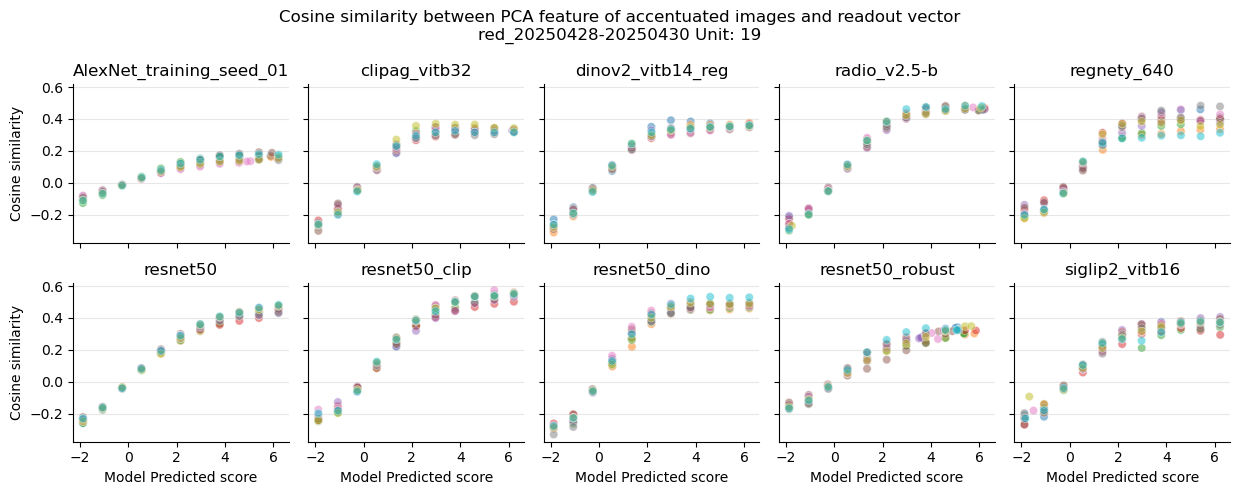

In [114]:
figh, axs = plt.subplots(2, 5, figsize=(12.5, 5), sharex=True, sharey=True)
for model_i, ax in enumerate(axs.flatten()):
    sns.scatterplot(x="score", y="cosine_similarity", data=cosine_results[model_i]["df"], ax=ax, hue="img_id", alpha=0.5, palette="tab10", legend=False)
    config = cosine_results[model_i]["config"]
    ax.set_title(f"{config['model_name']}") # , {config['layer_name']}
    ax.set_xlabel("Model Predicted score")
    ax.set_ylabel("Cosine similarity")
    ax.grid(True, axis='y', alpha=0.3)
plt.suptitle(f"Cosine similarity between PCA feature of accentuated images and readout vector\n{subject_id} Unit: {config['unit_ids'][0]}") #  <PCA feature, readout vector>
plt.tight_layout()
plt.show()

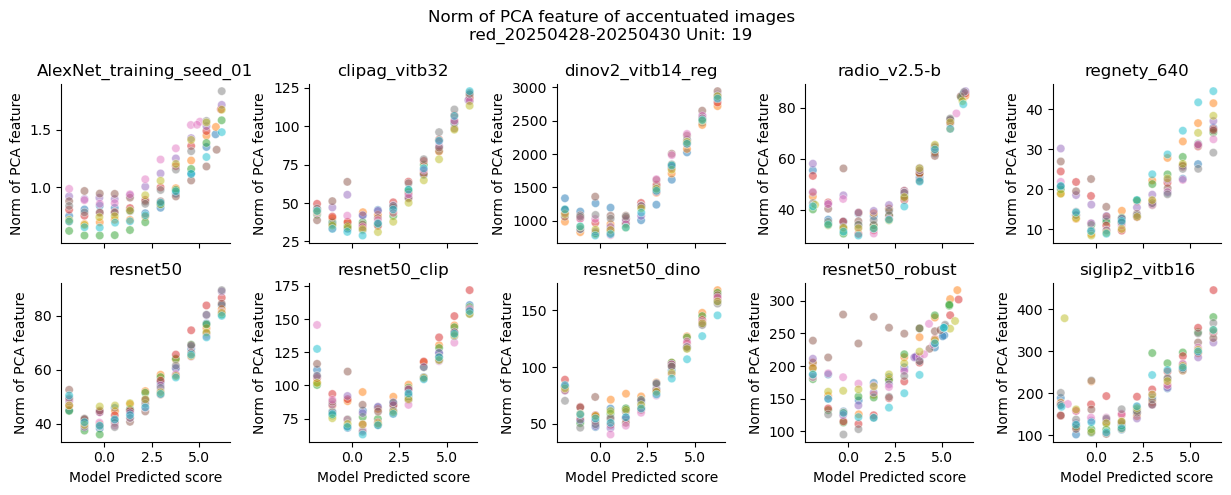

In [113]:
figh, axs = plt.subplots(2, 5, figsize=(12.5, 5), sharex=True, sharey=False)
for model_i, ax in enumerate(axs.flatten()):
    sns.scatterplot(x="score", y="PCA_norm", data=cosine_results[model_i]["df"], ax=ax, hue="img_id", alpha=0.5, palette="tab10", legend=False)
    config = cosine_results[model_i]["config"]
    ax.set_title(f"{config['model_name']}") # , {config['layer_name']}
    ax.set_xlabel("Model Predicted score")
    ax.set_ylabel("Norm of PCA feature")
plt.suptitle(f"Norm of PCA feature of accentuated images\n{subject_id} Unit: {config['unit_ids'][0]}")
plt.tight_layout()
plt.show()

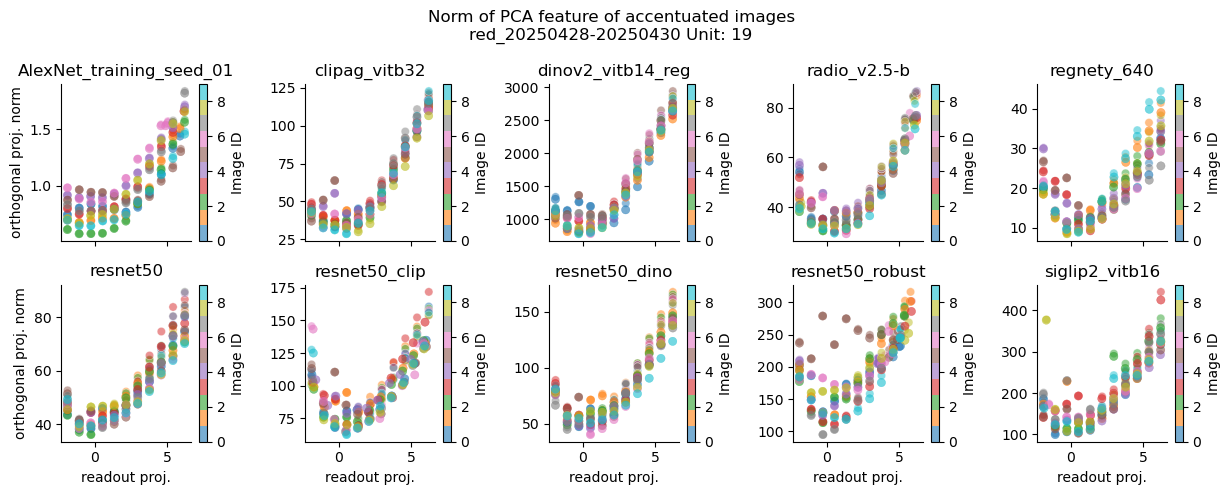

In [232]:
figh, axs = plt.subplots(2, 5, figsize=(12.5, 5), sharex=True, sharey=False)
for model_i, ax in enumerate(axs.flatten()):
    sns.scatterplot(x="score", y="PCA_norm", data=cosine_results[model_i]["df"], ax=ax, hue="img_id", alpha=0.5, palette="tab10", legend=False)
    config = cosine_results[model_i]["config"]
    ax.set_title(f"{config['model_name']}") # , {config['layer_name']}
    ax.set_xlabel("Model Predicted score")
    ax.set_ylabel("Norm of PCA feature")
    
    PCA_resp = torch.from_numpy(cosine_results[model_i]["PCA_resp"])
    readout_vec = cosine_results[model_i]["readout_vec"]
    acc_split_df = cosine_results[model_i]['df'].reset_index(drop=True)
    acc_config = cosine_results[model_i]["config"]
    readout_norm = readout_vec.norm()
    unit_readout_axis = readout_vec / readout_vec.norm()
    PCA_readout_proj = PCA_resp @ unit_readout_axis
    PCA_ortho = PCA_resp - PCA_readout_proj[:, None] @ unit_readout_axis[None, :]
    PCA_ortho_norm = PCA_ortho.norm(dim=1)

    scax = ax.scatter(PCA_readout_proj * readout_norm, PCA_ortho_norm, 
                # c=acc_split_df.score, cmap="tab10", lw=0.3, alpha=0.6)
                c=acc_split_df.img_id, cmap="tab10", lw=0.3, alpha=0.6)
    # plt.colorbar(label="Model Predicted score")
    plt.colorbar(scax, label="Image ID")
    ax.set_title(f"{config['model_name']}") # , {config['layer_name']}
    # ax.set_xlabel("PCA projected along readout vector")
    # ax.set_ylabel("PCA coef orthogonal to readout vector")
    if model_i == 0 or model_i == 5:
        ax.set_ylabel("orthogonal proj. norm")
    else:
        ax.set_ylabel("")
    if model_i >= 5:
        ax.set_xlabel("readout proj.")
    else:
        ax.set_xlabel("")
    
# plt.suptitle(f"PCA response of accentuated images\n{subject_id} Unit: {acc_config['unit_ids'][0]}\n{acc_config['model_name']} {acc_config['layer_name']}")
# plt.show()

plt.suptitle(f"Norm of PCA feature of accentuated images\n{subject_id} Unit: {config['unit_ids'][0]}")
plt.tight_layout()
plt.show()

In [115]:
cosine_results[0]["PCA_resp"].shape

(110, 750)

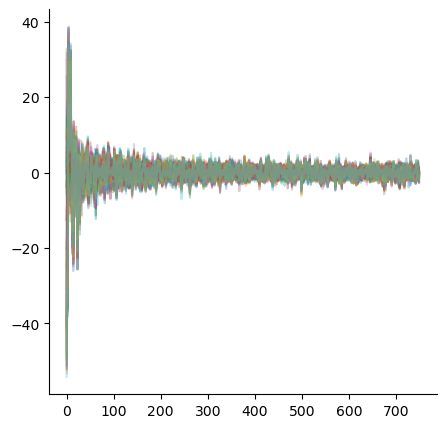

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(cosine_results[1]["PCA_resp"].T, alpha=0.3)
plt.show()

### Focused analysis

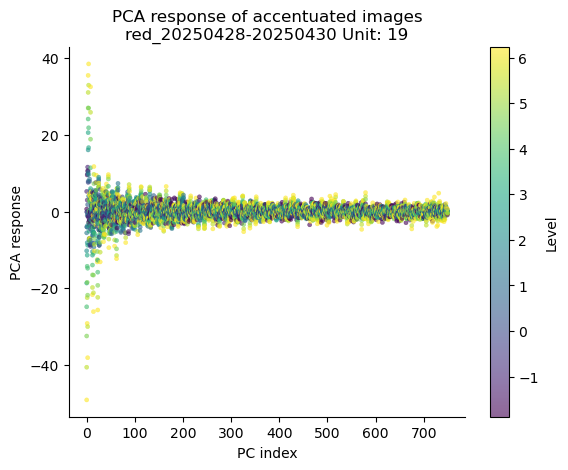

In [136]:
PCA_resp = cosine_results[1]["PCA_resp"]
split_df = cosine_results[1]['df'].reset_index(drop=True).query("img_id == 0")
PC_idxs = np.arange(PCA_resp.shape[1])[:, None].repeat(len(split_df), axis=1)
levels = split_df["level"].values[None, :].repeat(PCA_resp.shape[1], axis=0)
plt.scatter(PC_idxs, PCA_resp[split_df.index, :].T, c= levels, s=9, cmap="viridis", lw=0.3, alpha=0.6)
# plt.plot(PC_idxs, PCA_resp[split_df.index, :].T, lw=0.3, alpha=0.3)
plt.colorbar(label="Level")
plt.xlabel("PC index")
plt.ylabel("PCA response")
plt.title(f"PCA response of accentuated images\n{subject_id} Unit: {config['unit_ids'][0]}")
plt.show()

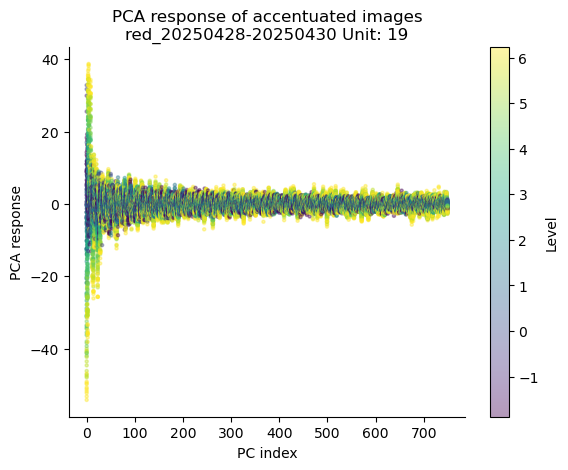

In [145]:
PCA_resp = cosine_results[1]["PCA_resp"]
split_df = cosine_results[1]['df'].reset_index(drop=True)
PC_idxs = np.arange(PCA_resp.shape[1])[:, None].repeat(len(split_df), axis=1)
levels = split_df["level"].values[None, :].repeat(PCA_resp.shape[1], axis=0)
plt.scatter(PC_idxs, PCA_resp[split_df.index, :].T, c= levels, s=5, cmap="viridis", alpha=0.4)
# plt.plot(PC_idxs, PCA_resp[split_df.index, :].T, lw=0.3, alpha=0.3)
plt.colorbar(label="Level")
plt.xlabel("PC index")
plt.ylabel("PCA response")
plt.title(f"PCA response of accentuated images\n{subject_id} Unit: {config['unit_ids'][0]}")
plt.show()

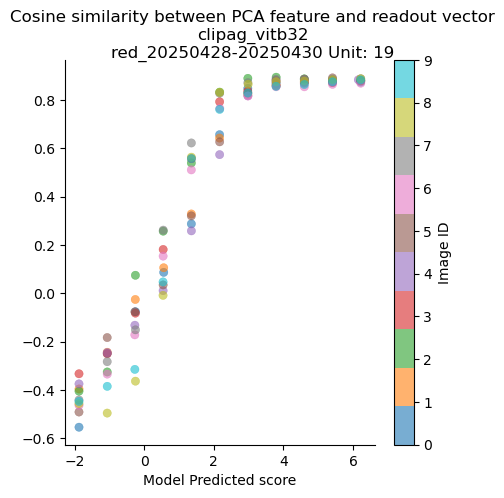

In [156]:
acc_split_df = cosine_results[1]['df'].reset_index(drop=True)
acc_config = cosine_results[1]["config"]
PCA_resp = cosine_results[1]["PCA_resp"]
readout_vec = cosine_results[1]["readout_vec"]
PC_slice = slice(0, 20)
cosine_sim_topPCs = cosine_similarity(PCA_resp[:, PC_slice], readout_vec.numpy().reshape(1, -1)[:, PC_slice])
cosine_sim_topPCs = cosine_sim_topPCs.flatten()
plt.figure(figsize=(5, 5))
plt.scatter(acc_split_df.score, cosine_sim_topPCs, c=acc_split_df.img_id.values.astype(float), cmap="tab10", lw=0.3, alpha=0.6)
plt.colorbar(label="Image ID")
plt.xlabel("Model Predicted score")
# plt.ylabel("Cosine similarity <PCA feature, readout vector>")
plt.suptitle(f"Cosine similarity between PCA feature and readout vector\n{acc_config['model_name']}\n{subject_id} Unit: {acc_config['unit_ids'][0]}")
plt.show()

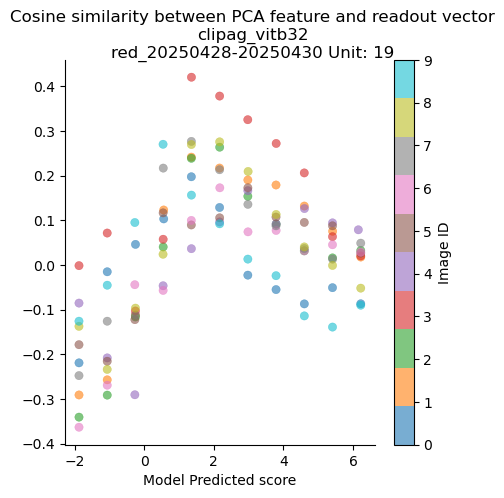

In [ ]:
acc_split_df = cosine_results[1]['df'].reset_index(drop=True)
acc_config = cosine_results[1]["config"]
PCA_resp = cosine_results[1]["PCA_resp"]
readout_vec = cosine_results[1]["readout_vec"]
PC_slice = slice(100, 150)
cosine_sim_topPCs = cosine_similarity(PCA_resp[:, PC_slice], readout_vec.numpy().reshape(1, -1)[:, PC_slice])
cosine_sim_topPCs = cosine_sim_topPCs.flatten()
plt.figure(figsize=(5, 5))
plt.scatter(acc_split_df.score, cosine_sim_topPCs, 
            c=acc_split_df.img_id, cmap="tab10", lw=0.3, alpha=0.6)
plt.colorbar(label="Image ID")
plt.xlabel("Model Predicted score")
# plt.ylabel("Cosine similarity <PCA feature, readout vector>")
plt.suptitle(f"Cosine similarity between PCA feature and readout vector\n{acc_config['model_name']}\n{subject_id} Unit: {acc_config['unit_ids'][0]}")
plt.show()

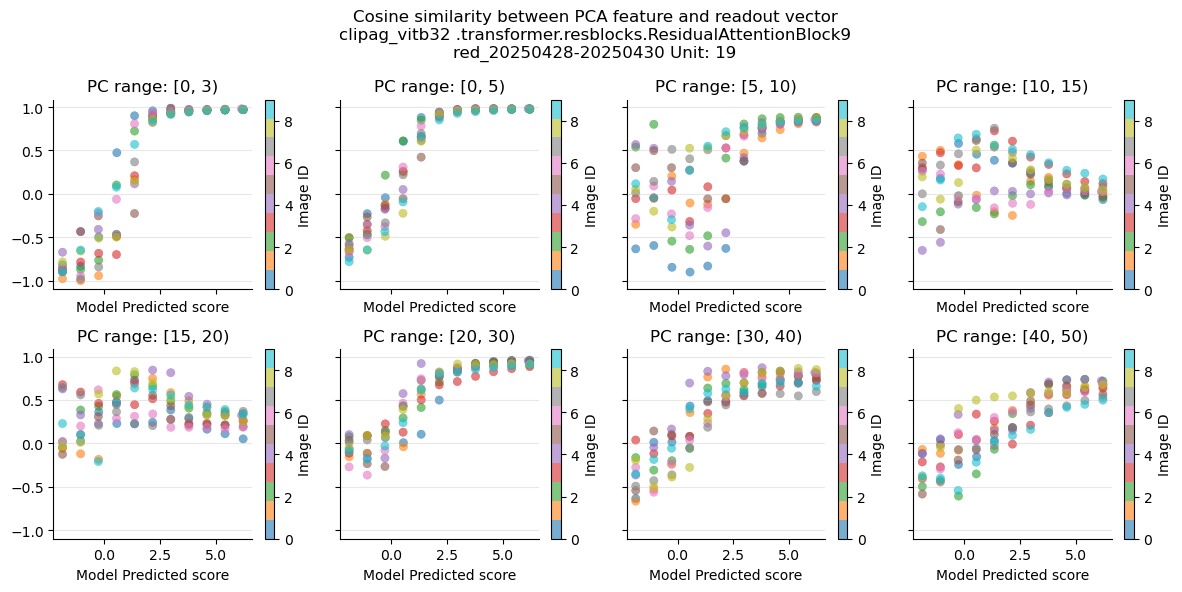

In [197]:
acc_split_df = cosine_results[1]['df'].reset_index(drop=True)
acc_config = cosine_results[1]["config"]
PCA_resp = cosine_results[1]["PCA_resp"]
readout_vec = cosine_results[1]["readout_vec"]
PC_slice = slice(100, 150)

figh, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for PC_slice, ax in zip([slice(0, 3), slice(0, 5), slice(5, 10), slice(10, 15), slice(15, 20),
                         slice(20, 30), slice(30, 40), slice(40, 50), 
                         ], axs.flatten()):
    plt.sca(ax)
    cosine_sim_topPCs = cosine_similarity(PCA_resp[:, PC_slice], readout_vec.numpy().reshape(1, -1)[:, PC_slice])
    cosine_sim_topPCs = cosine_sim_topPCs.flatten()
    plt.scatter(acc_split_df.score, cosine_sim_topPCs, 
                c=acc_split_df.img_id, cmap="tab10", lw=0.3, alpha=0.6)
    plt.grid(True, axis='y', alpha=0.3)
    plt.colorbar(label="Image ID")
    plt.xlabel("Model Predicted score")
    plt.title(f"PC range: [{PC_slice.start}, {PC_slice.stop})")
# plt.ylabel("Cosine similarity <PCA feature, readout vector>")
plt.suptitle(f"Cosine similarity between PCA feature and readout vector\n{acc_config['model_name']} {acc_config['layer_name']}\n{subject_id} Unit: {acc_config['unit_ids'][0]}")
plt.tight_layout()
plt.show()

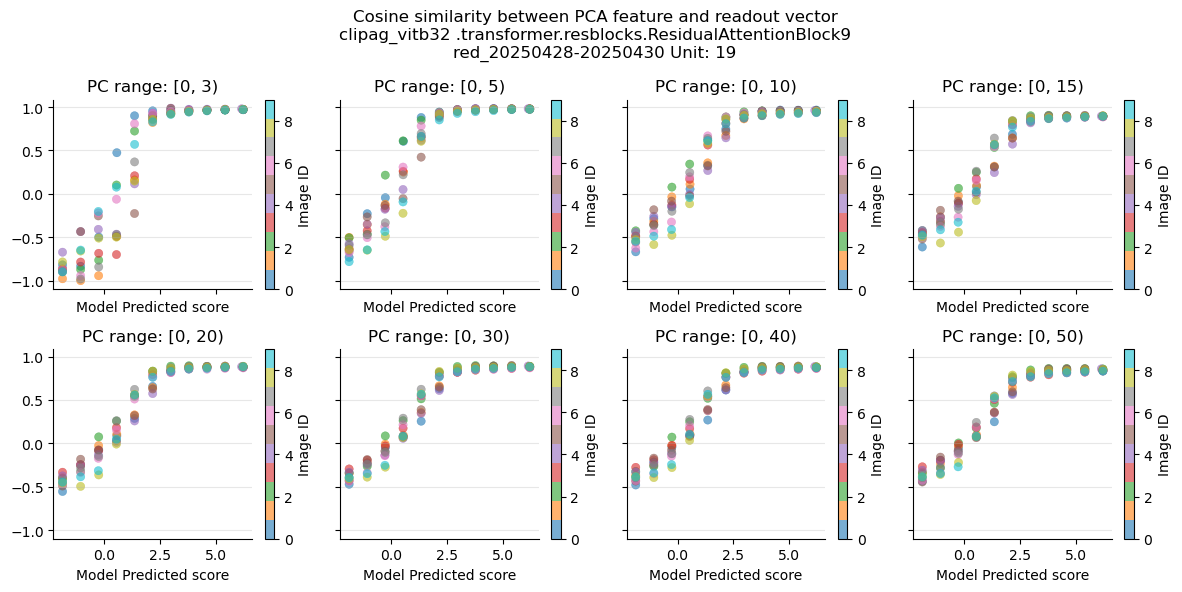

In [198]:
acc_split_df = cosine_results[1]['df'].reset_index(drop=True)
acc_config = cosine_results[1]["config"]
PCA_resp = cosine_results[1]["PCA_resp"]
readout_vec = cosine_results[1]["readout_vec"]
PC_slice = slice(100, 150)

figh, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for PC_slice, ax in zip([slice(0, 3), slice(0, 5), slice(0, 10), slice(0, 15), slice(0, 20),
                         slice(0, 30), slice(0, 40), slice(0, 50), 
                         ], axs.flatten()):
    plt.sca(ax)
    cosine_sim_topPCs = cosine_similarity(PCA_resp[:, PC_slice], readout_vec.numpy().reshape(1, -1)[:, PC_slice])
    cosine_sim_topPCs = cosine_sim_topPCs.flatten()
    plt.scatter(acc_split_df.score, cosine_sim_topPCs, 
                c=acc_split_df.img_id, cmap="tab10", lw=0.3, alpha=0.6)
    plt.grid(True, axis='y', alpha=0.3)
    plt.colorbar(label="Image ID")
    plt.xlabel("Model Predicted score")
    plt.title(f"PC range: [{PC_slice.start}, {PC_slice.stop})")
# plt.ylabel("Cosine similarity <PCA feature, readout vector>")
plt.suptitle(f"Cosine similarity between PCA feature and readout vector\n{acc_config['model_name']} {acc_config['layer_name']}\n{subject_id} Unit: {acc_config['unit_ids'][0]}")
plt.tight_layout()
plt.show()

In [204]:
readout_vec.numpy()[PC_slice].shape

(3,)

In [205]:
PCA_resp[:, PC_slice].T.shape

(3, 110)

In [206]:
np.corrcoef(PCA_resp[:, PC_slice].T, readout_vec.numpy()[PC_slice][:, None], rowvar=False)[:-1, -1]

array([ 0.98678995,  0.99563113,  0.44287284,  0.77152086,  0.89153658,
        0.88779007,  0.57756842,  0.31170945,  0.12874523, -0.06740591,
       -0.10396182, -0.38225041, -0.98395641, -0.87372459, -0.73275094,
       -0.33693172,  0.24101803,  0.22597399,  0.24995935,  0.26000064,
        0.21091878,  0.18470012, -0.74097467, -0.66099332, -0.62285982,
       -0.35183402, -0.13832866,  0.07877622,  0.15644725,  0.16551756,
        0.05927427,  0.04729956, -0.01795061,  0.9069576 ,  0.97395653,
        0.99556821,  0.74176305,  0.72402297,  0.53818971,  0.4971412 ,
        0.42032318,  0.38266962,  0.28398825,  0.24650884,  0.03851938,
        0.10955122, -0.0350519 ,  0.00114273,  0.09282099, -0.24074886,
       -0.03875596,  0.01086271, -0.0124262 ,  0.0011442 ,  0.0179501 ,
        0.20796378,  0.24842155,  0.10902707,  0.55618629,  0.77391521,
        0.51189063,  0.40619438,  0.02338019,  0.03459517, -0.04130649,
        0.0026545 ,  0.07532402, -0.49769991, -0.68058781,  0.99

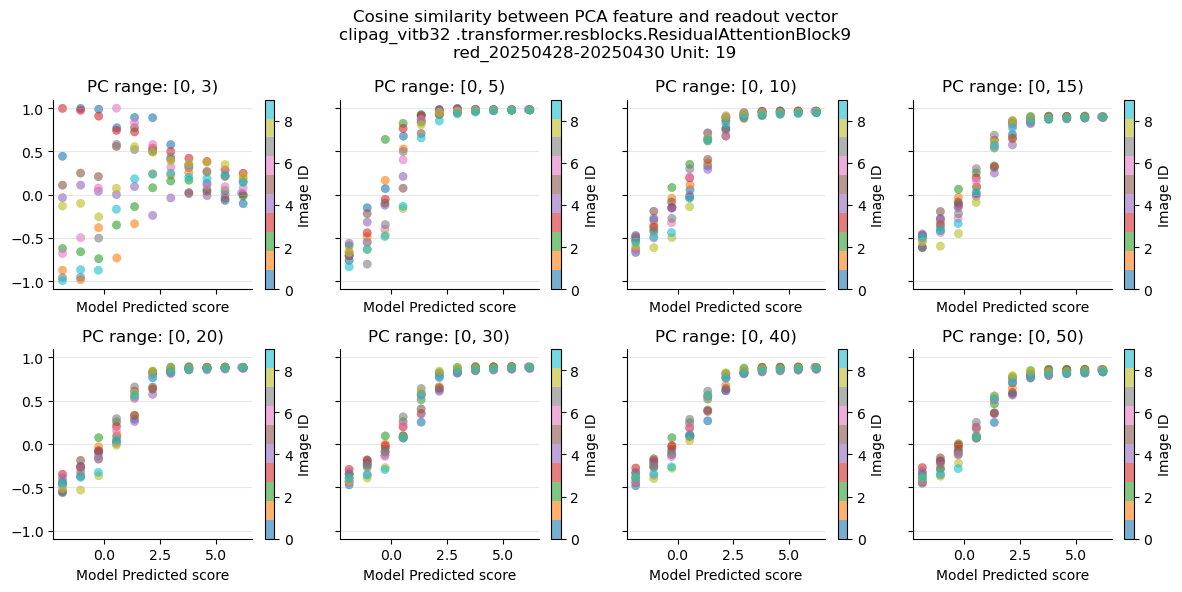

In [208]:
acc_split_df = cosine_results[1]['df'].reset_index(drop=True)
acc_config = cosine_results[1]["config"]
PCA_resp = cosine_results[1]["PCA_resp"]
readout_vec = cosine_results[1]["readout_vec"]
PC_slice = slice(100, 150)

figh, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for PC_slice, ax in zip([slice(0, 3), slice(0, 5), slice(0, 10), slice(0, 15), slice(0, 20),
                         slice(0, 30), slice(0, 40), slice(0, 50), 
                         ], axs.flatten()):
    plt.sca(ax)
    pearson_corr_topPCs = np.corrcoef(PCA_resp[:, PC_slice].T, readout_vec.numpy()[PC_slice][:, None], rowvar=False)[:-1, -1]
    cosine_sim_topPCs = pearson_corr_topPCs
    cosine_sim_topPCs = cosine_sim_topPCs.flatten()
    plt.scatter(acc_split_df.score, cosine_sim_topPCs, 
                c=acc_split_df.img_id, cmap="tab10", lw=0.3, alpha=0.6)
    plt.grid(True, axis='y', alpha=0.3)
    plt.colorbar(label="Image ID")
    plt.xlabel("Model Predicted score")
    plt.title(f"PC range: [{PC_slice.start}, {PC_slice.stop})")
# plt.ylabel("Cosine similarity <PCA feature, readout vector>")
plt.suptitle(f"Cosine similarity between PCA feature and readout vector\n{acc_config['model_name']} {acc_config['layer_name']}\n{subject_id} Unit: {acc_config['unit_ids'][0]}")
plt.tight_layout()
plt.show()

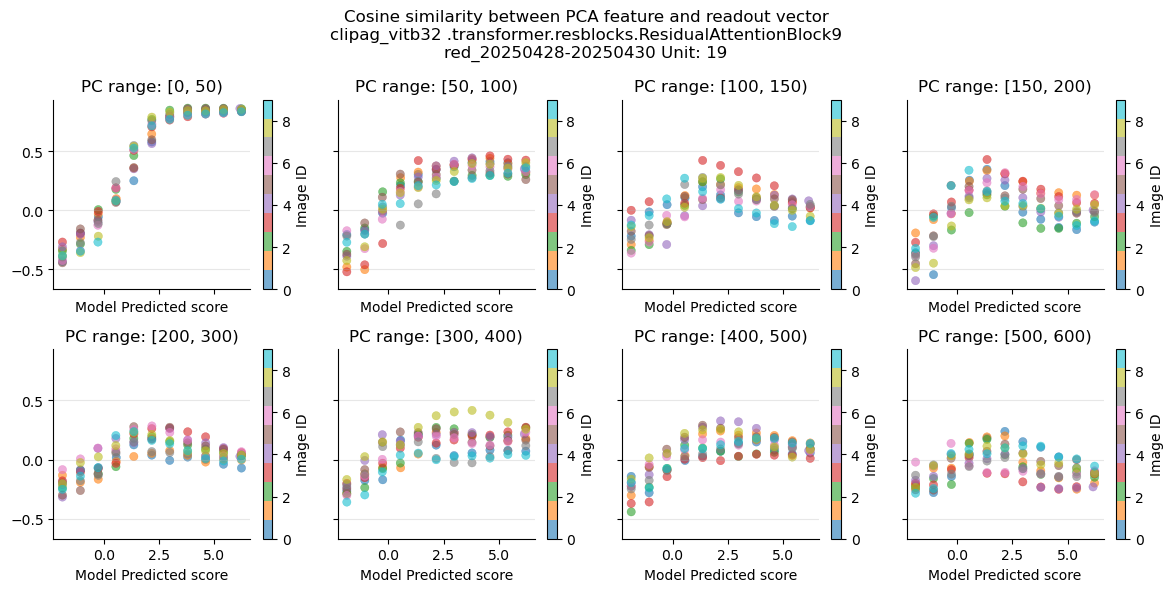

In [170]:
acc_split_df = cosine_results[1]['df'].reset_index(drop=True)
acc_config = cosine_results[1]["config"]
PCA_resp = cosine_results[1]["PCA_resp"]
readout_vec = cosine_results[1]["readout_vec"]
PC_slice = slice(100, 150)

figh, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for PC_slice, ax in zip([slice(0, 50), slice(50, 100), slice(100, 150), slice(150, 200),
                         slice(200, 300), slice(300, 400), slice(400, 500), slice(500, 600)
                         ], axs.flatten()):
    plt.sca(ax)
    cosine_sim_topPCs = cosine_similarity(PCA_resp[:, PC_slice], readout_vec.numpy().reshape(1, -1)[:, PC_slice])
    cosine_sim_topPCs = cosine_sim_topPCs.flatten()
    plt.scatter(acc_split_df.score, cosine_sim_topPCs, 
                c=acc_split_df.img_id, cmap="tab10", lw=0.3, alpha=0.6)
    plt.grid(True, axis='y', alpha=0.3)
    plt.colorbar(label="Image ID")
    plt.xlabel("Model Predicted score")
    plt.title(f"PC range: [{PC_slice.start}, {PC_slice.stop})")
# plt.ylabel("Cosine similarity <PCA feature, readout vector>")
plt.suptitle(f"Cosine similarity between PCA feature and readout vector\n{acc_config['model_name']} {acc_config['layer_name']}\n{subject_id} Unit: {acc_config['unit_ids'][0]}")
plt.tight_layout()
plt.show()

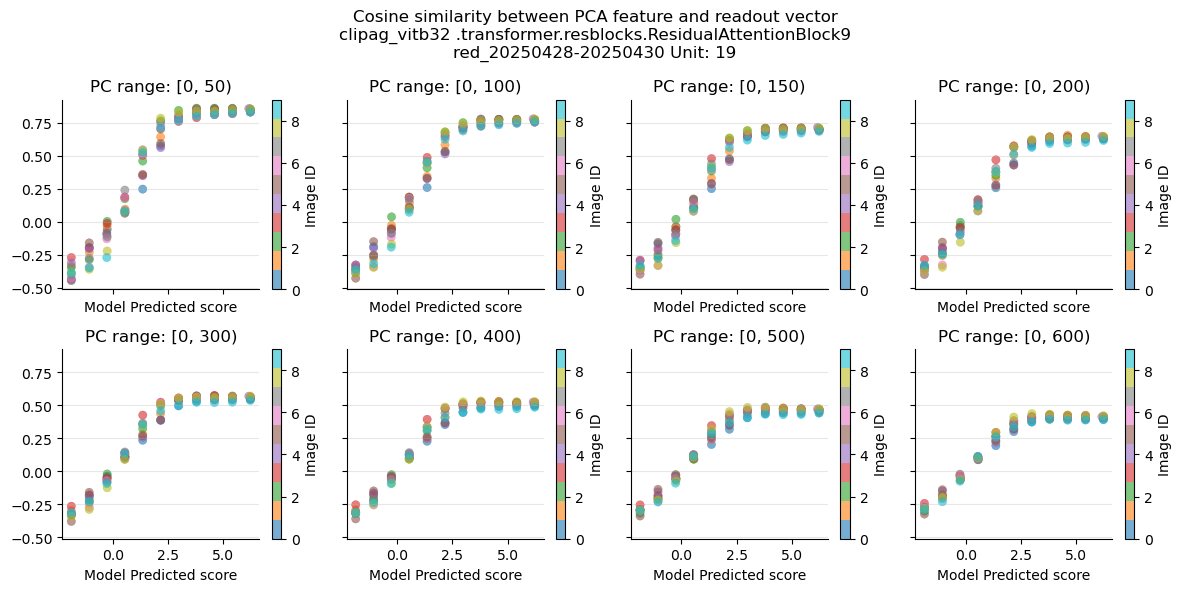

In [169]:
acc_split_df = cosine_results[1]['df'].reset_index(drop=True)
acc_config = cosine_results[1]["config"]
PCA_resp = cosine_results[1]["PCA_resp"]
readout_vec = cosine_results[1]["readout_vec"]
PC_slice = slice(100, 150)

figh, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for PC_slice, ax in zip([slice(0, 50), slice(0, 100), slice(0, 150), slice(0, 200),
                         slice(0, 300), slice(0, 400), slice(0, 500), slice(0, 600)
                         ], axs.flatten()):
    plt.sca(ax)
    cosine_sim_topPCs = cosine_similarity(PCA_resp[:, PC_slice], readout_vec.numpy().reshape(1, -1)[:, PC_slice])
    cosine_sim_topPCs = cosine_sim_topPCs.flatten()
    plt.scatter(acc_split_df.score, cosine_sim_topPCs, 
                c=acc_split_df.img_id, cmap="tab10", lw=0.3, alpha=0.6)
    plt.grid(True, axis='y', alpha=0.3)
    plt.colorbar(label="Image ID")
    plt.xlabel("Model Predicted score")
    plt.title(f"PC range: [{PC_slice.start}, {PC_slice.stop})")
# plt.ylabel("Cosine similarity <PCA feature, readout vector>")
plt.suptitle(f"Cosine similarity between PCA feature and readout vector\n{acc_config['model_name']} {acc_config['layer_name']}\n{subject_id} Unit: {acc_config['unit_ids'][0]}")
plt.tight_layout()
plt.show()

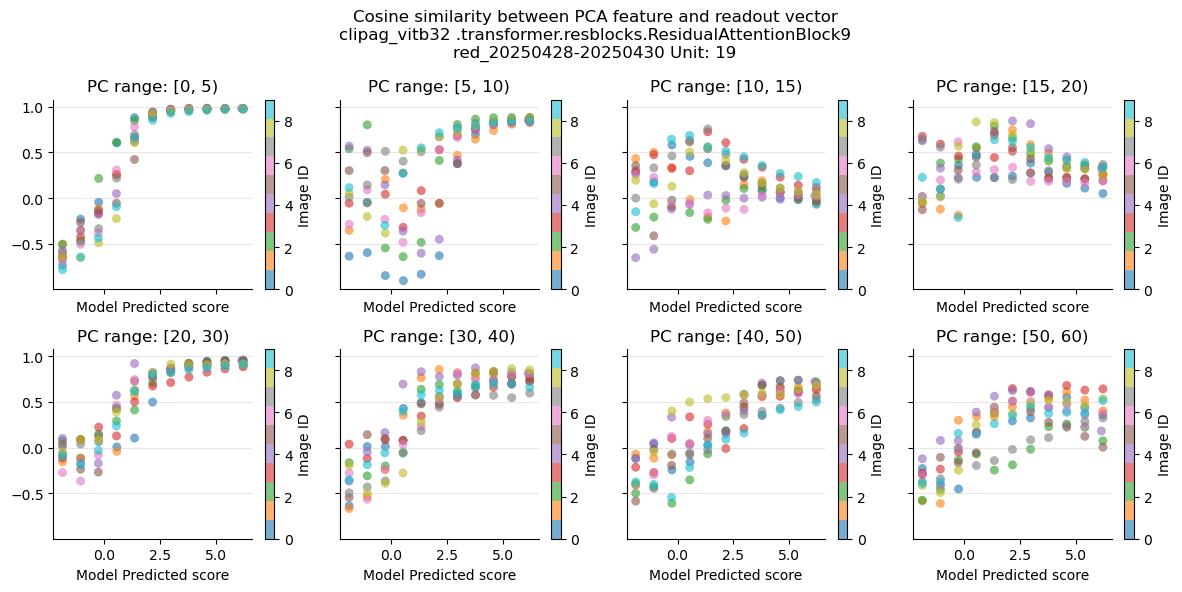

In [211]:
acc_split_df = cosine_results[1]['df'].reset_index(drop=True)
acc_config = cosine_results[1]["config"]
PCA_resp = cosine_results[1]["PCA_resp"]
readout_vec = cosine_results[1]["readout_vec"]
PC_slice = slice(100, 150)

figh, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for PC_slice, ax in zip([slice(0, 5), slice(5, 10), slice(10, 15), slice(15, 20),
                         slice(20, 30), slice(30, 40), slice(40, 50), slice(50, 60)
                         ], axs.flatten()):
    plt.sca(ax)
    cosine_sim_topPCs = cosine_similarity(PCA_resp[:, PC_slice], readout_vec.numpy().reshape(1, -1)[:, PC_slice])
    cosine_sim_topPCs = cosine_sim_topPCs.flatten()
    plt.scatter(acc_split_df.score, cosine_sim_topPCs, 
                c=acc_split_df.img_id, cmap="tab10", lw=0.3, alpha=0.6)
    plt.grid(True, axis='y', alpha=0.3)
    plt.colorbar(label="Image ID")
    plt.xlabel("Model Predicted score")
    plt.title(f"PC range: [{PC_slice.start}, {PC_slice.stop})")
# plt.ylabel("Cosine similarity <PCA feature, readout vector>")
plt.suptitle(f"Cosine similarity between PCA feature and readout vector\n{acc_config['model_name']} {acc_config['layer_name']}\n{subject_id} Unit: {acc_config['unit_ids'][0]}")
plt.tight_layout()
plt.show()

In [227]:
plt.close("all")

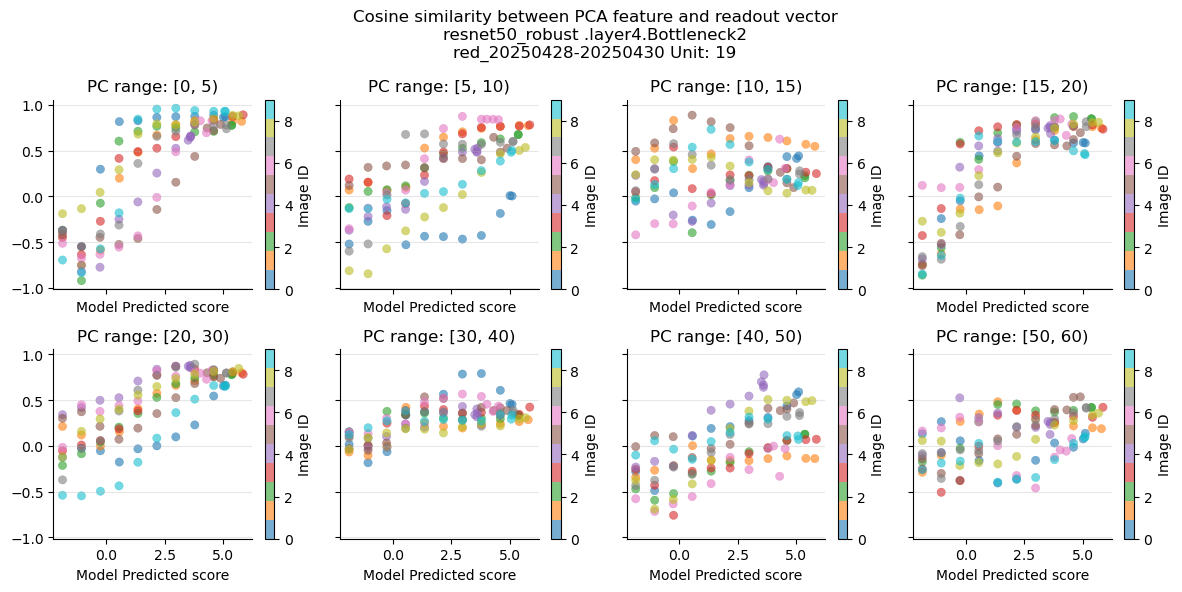

In [209]:
acc_split_df = cosine_results[-2]['df'].reset_index(drop=True)
acc_config = cosine_results[-2]["config"]
PCA_resp = cosine_results[-2]["PCA_resp"]
readout_vec = cosine_results[-2]["readout_vec"]
PC_slice = slice(100, 150)

figh, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for PC_slice, ax in zip([slice(0, 5), slice(5, 10), slice(10, 15), slice(15, 20),
                         slice(20, 30), slice(30, 40), slice(40, 50), slice(50, 60)
                         ], axs.flatten()):
    plt.sca(ax)
    cosine_sim_topPCs = cosine_similarity(PCA_resp[:, PC_slice], readout_vec.numpy().reshape(1, -1)[:, PC_slice])
    cosine_sim_topPCs = cosine_sim_topPCs.flatten()
    plt.scatter(acc_split_df.score, cosine_sim_topPCs, 
                c=acc_split_df.img_id, cmap="tab10", lw=0.3, alpha=0.6)
    plt.grid(True, axis='y', alpha=0.3)
    plt.colorbar(label="Image ID")
    plt.xlabel("Model Predicted score")
    plt.title(f"PC range: [{PC_slice.start}, {PC_slice.stop})")
# plt.ylabel("Cosine similarity <PCA feature, readout vector>")
plt.suptitle(f"Cosine similarity between PCA feature and readout vector\n{acc_config['model_name']} {acc_config['layer_name']}\n{subject_id} Unit: {acc_config['unit_ids'][0]}")
plt.tight_layout()
plt.show()

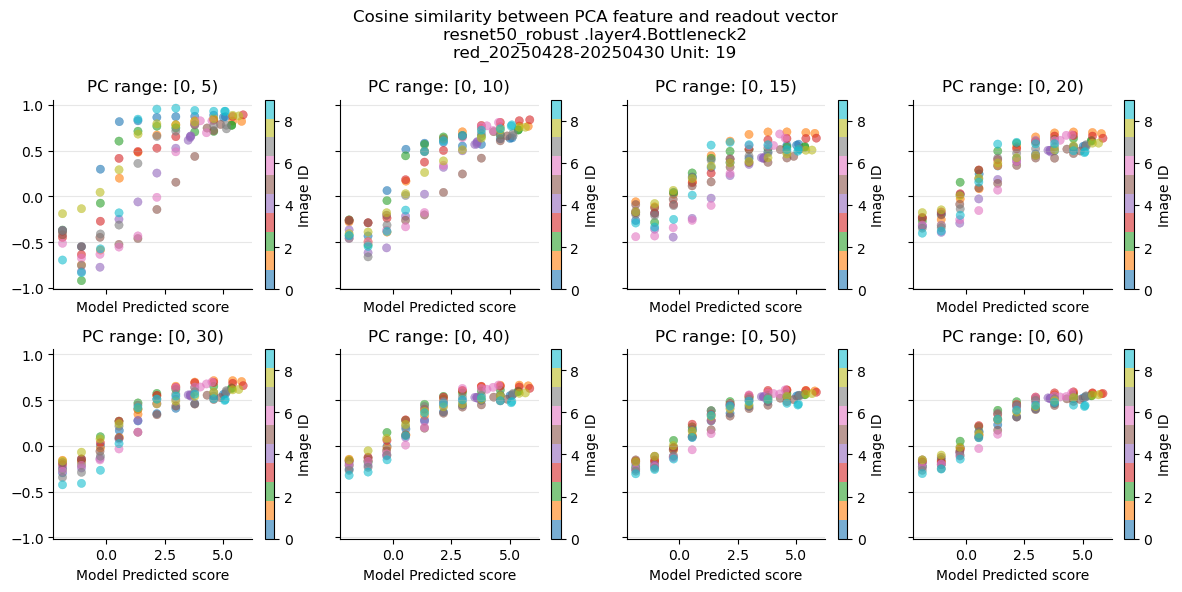

In [210]:
acc_split_df = cosine_results[-2]['df'].reset_index(drop=True)
acc_config = cosine_results[-2]["config"]
PCA_resp = cosine_results[-2]["PCA_resp"]
readout_vec = cosine_results[-2]["readout_vec"]
PC_slice = slice(100, 150)

figh, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for PC_slice, ax in zip([slice(0, 5), slice(0, 10), slice(0, 15), slice(0, 20),
                         slice(0, 30), slice(0, 40), slice(0, 50), slice(0, 60)
                         ], axs.flatten()):
    plt.sca(ax)
    cosine_sim_topPCs = cosine_similarity(PCA_resp[:, PC_slice], readout_vec.numpy().reshape(1, -1)[:, PC_slice])
    cosine_sim_topPCs = cosine_sim_topPCs.flatten()
    plt.scatter(acc_split_df.score, cosine_sim_topPCs, 
                c=acc_split_df.img_id, cmap="tab10", lw=0.3, alpha=0.6)
    plt.grid(True, axis='y', alpha=0.3)
    plt.colorbar(label="Image ID")
    plt.xlabel("Model Predicted score")
    plt.title(f"PC range: [{PC_slice.start}, {PC_slice.stop})")
# plt.ylabel("Cosine similarity <PCA feature, readout vector>")
plt.suptitle(f"Cosine similarity between PCA feature and readout vector\n{acc_config['model_name']} {acc_config['layer_name']}\n{subject_id} Unit: {acc_config['unit_ids'][0]}")
plt.tight_layout()
plt.show()

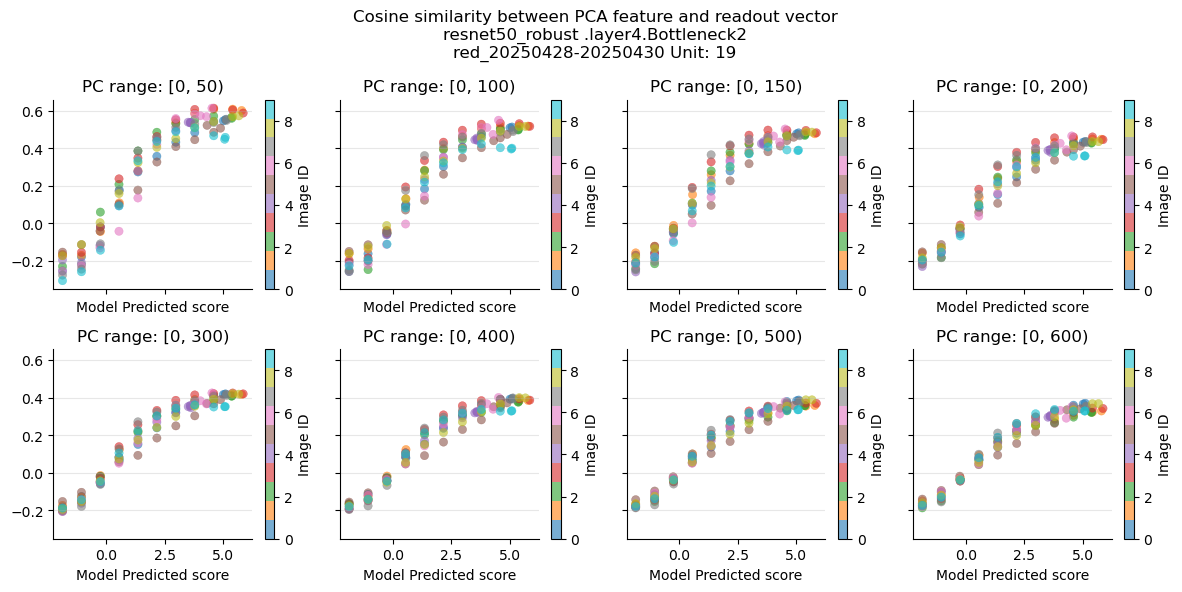

In [171]:
acc_split_df = cosine_results[-2]['df'].reset_index(drop=True)
acc_config = cosine_results[-2]["config"]
PCA_resp = cosine_results[-2]["PCA_resp"]
readout_vec = cosine_results[-2]["readout_vec"]
PC_slice = slice(100, 150)

figh, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for PC_slice, ax in zip([slice(0, 50), slice(0, 100), slice(0, 150), slice(0, 200),
                         slice(0, 300), slice(0, 400), slice(0, 500), slice(0, 600)
                         ], axs.flatten()):
    plt.sca(ax)
    cosine_sim_topPCs = cosine_similarity(PCA_resp[:, PC_slice], readout_vec.numpy().reshape(1, -1)[:, PC_slice])
    cosine_sim_topPCs = cosine_sim_topPCs.flatten()
    plt.scatter(acc_split_df.score, cosine_sim_topPCs, 
                c=acc_split_df.img_id, cmap="tab10", lw=0.3, alpha=0.6)
    plt.grid(True, axis='y', alpha=0.3)
    plt.colorbar(label="Image ID")
    plt.xlabel("Model Predicted score")
    plt.title(f"PC range: [{PC_slice.start}, {PC_slice.stop})")
# plt.ylabel("Cosine similarity <PCA feature, readout vector>")
plt.suptitle(f"Cosine similarity between PCA feature and readout vector\n{acc_config['model_name']} {acc_config['layer_name']}\n{subject_id} Unit: {acc_config['unit_ids'][0]}")
plt.tight_layout()
plt.show()

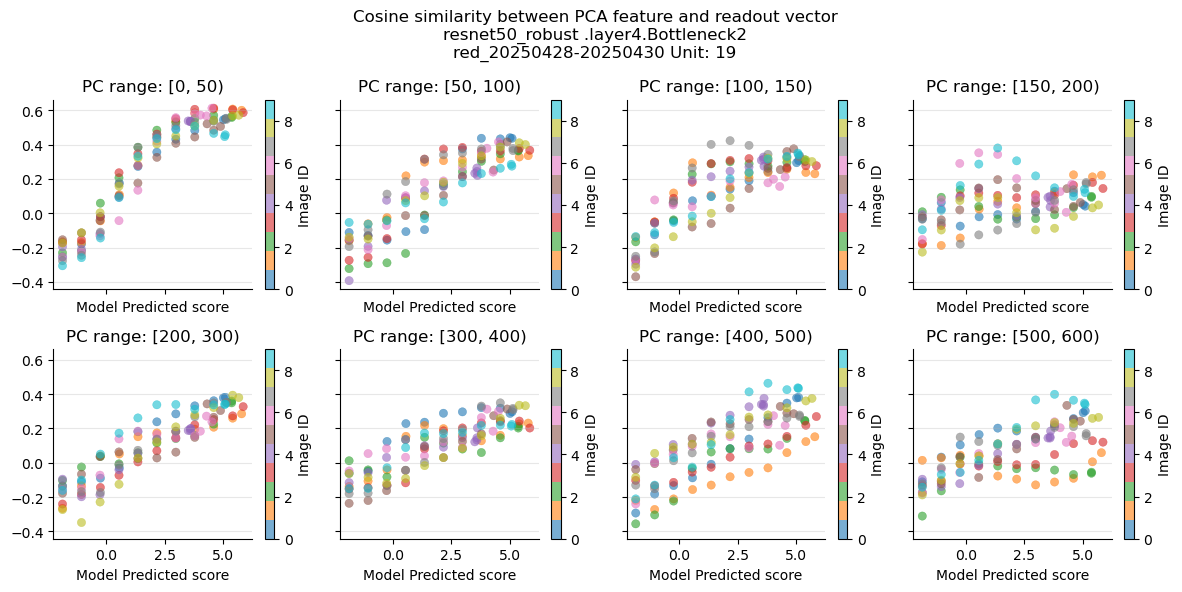

In [172]:
acc_split_df = cosine_results[-2]['df'].reset_index(drop=True)
acc_config = cosine_results[-2]["config"]
PCA_resp = cosine_results[-2]["PCA_resp"]
readout_vec = cosine_results[-2]["readout_vec"]
PC_slice = slice(100, 150)

figh, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for PC_slice, ax in zip([slice(0, 50), slice(50, 100), slice(100, 150), slice(150, 200),
                         slice(200, 300), slice(300, 400), slice(400, 500), slice(500, 600)
                         ], axs.flatten()):
    plt.sca(ax)
    cosine_sim_topPCs = cosine_similarity(PCA_resp[:, PC_slice], readout_vec.numpy().reshape(1, -1)[:, PC_slice])
    cosine_sim_topPCs = cosine_sim_topPCs.flatten()
    plt.scatter(acc_split_df.score, cosine_sim_topPCs, 
                c=acc_split_df.img_id, cmap="tab10", lw=0.3, alpha=0.6)
    plt.grid(True, axis='y', alpha=0.3)
    plt.colorbar(label="Image ID")
    plt.xlabel("Model Predicted score")
    plt.title(f"PC range: [{PC_slice.start}, {PC_slice.stop})")
# plt.ylabel("Cosine similarity <PCA feature, readout vector>")
plt.suptitle(f"Cosine similarity between PCA feature and readout vector\n{acc_config['model_name']} {acc_config['layer_name']}\n{subject_id} Unit: {acc_config['unit_ids'][0]}")
plt.tight_layout()
plt.show()

### Geometry along and ortho to the accentuation axis

In [173]:
acc_split_df = cosine_results[-2]['df'].reset_index(drop=True)
acc_config = cosine_results[-2]["config"]
PCA_resp = cosine_results[-2]["PCA_resp"]
readout_vec = cosine_results[-2]["readout_vec"]

In [ ]:
acc_split_df = cosine_results[-2]['df'].reset_index(drop=True)
acc_config = cosine_results[-2]["config"]
PCA_resp = cosine_results[-2]["PCA_resp"]
readout_vec = cosine_results[-2]["readout_vec"]
PC_slice = slice(100, 150)

figh, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for PC_slice, ax in zip([slice(0, 50), slice(50, 100), slice(100, 150), slice(150, 200),
                         slice(200, 300), slice(300, 400), slice(400, 500), slice(500, 600)
                         ], axs.flatten()):
    plt.sca(ax)
    cosine_sim_topPCs = cosine_similarity(PCA_resp[:, PC_slice], readout_vec.numpy().reshape(1, -1)[:, PC_slice])
    cosine_sim_topPCs = cosine_sim_topPCs.flatten()
    plt.scatter(acc_split_df.score, cosine_sim_topPCs, 
                c=acc_split_df.img_id, cmap="tab10", lw=0.3, alpha=0.6)
    plt.grid(True, axis='y', alpha=0.3)
    plt.colorbar(label="Image ID")
    plt.xlabel("Model Predicted score")
    plt.title(f"PC range: [{PC_slice.start}, {PC_slice.stop})")
# plt.ylabel("Cosine similarity <PCA feature, readout vector>")
plt.suptitle(f"Cosine similarity between PCA feature and readout vector\n{acc_config['model_name']} {acc_config['layer_name']}\n{subject_id} Unit: {acc_config['unit_ids'][0]}")
plt.tight_layout()
plt.show()

In [174]:

PCA_resp.shape

(110, 750)

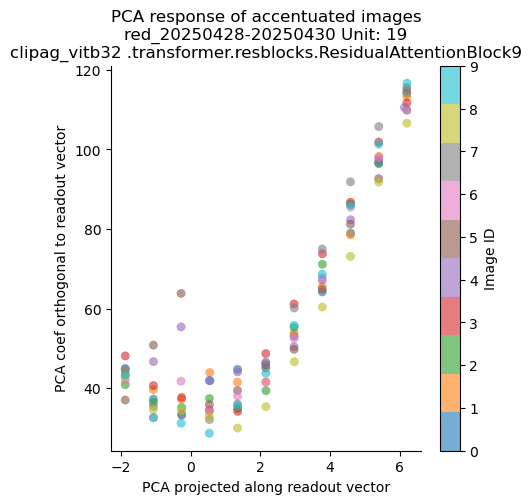

In [191]:
model_i = 1
PCA_resp = torch.from_numpy(cosine_results[model_i]["PCA_resp"])
readout_vec = cosine_results[model_i]["readout_vec"]
acc_split_df = cosine_results[model_i]['df'].reset_index(drop=True)
acc_config = cosine_results[model_i]["config"]
readout_norm = readout_vec.norm()
unit_readout_axis = readout_vec / readout_vec.norm()
PCA_readout_proj = PCA_resp @ unit_readout_axis
PCA_ortho = PCA_resp - PCA_readout_proj[:, None] @ unit_readout_axis[None, :]
PCA_ortho_norm = PCA_ortho.norm(dim=1)

plt.figure(figsize=(5, 5))
plt.scatter(PCA_readout_proj * readout_norm, PCA_ortho_norm, 
            # c=acc_split_df.score, cmap="tab10", lw=0.3, alpha=0.6)
            c=acc_split_df.img_id, cmap="tab10", lw=0.3, alpha=0.6)
# plt.colorbar(label="Model Predicted score")
plt.colorbar(label="Image ID")
plt.xlabel("PCA projected along readout vector")
plt.ylabel("PCA coef orthogonal to readout vector")
plt.title(f"PCA response of accentuated images\n{subject_id} Unit: {acc_config['unit_ids'][0]}\n{acc_config['model_name']} {acc_config['layer_name']}")
plt.show()


### Three-d PC123 plots

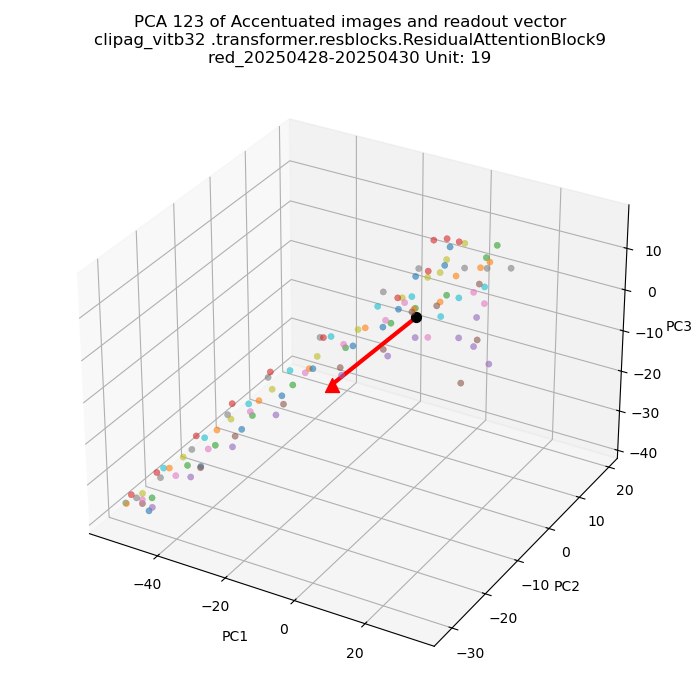

In [ ]:
acc_split_df = cosine_results[1]['df'].reset_index(drop=True)
acc_config = cosine_results[1]["config"]
PCA_resp = cosine_results[1]["PCA_resp"]
readout_vec = cosine_results[1]["readout_vec"]
PC_slice = slice(100, 150)
# three d plot of PCA 123 and readout vector
%matplotlib widget
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(PCA_resp[:, 0], PCA_resp[:, 1], PCA_resp[:, 2], 
           c=acc_split_df.img_id, cmap="tab10", lw=0.3, alpha=0.6)
# Plot readout vector as arrow from origin
# ax.quiver(0, 0, 0, readout_vec[0] * 500, readout_vec[1] * 500, readout_vec[2] * 500, 
#           color="red", arrow_length_ratio=0.3, linewidth=3, label="Readout vector")
ax.plot([0, readout_vec[0] * 500], [0, readout_vec[1] * 500], [0, readout_vec[2] * 500], color="red", linewidth=3)
ax.scatter(readout_vec[0] * 500, readout_vec[1] * 500, readout_vec[2] * 500, color="red", s=100, marker="^")
ax.scatter(0, 0, 0, c="black", s=50, marker="o")  # Mark origin
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title(f"PCA 123 of Accentuated images and readout vector\n{acc_config['model_name']} {acc_config['layer_name']}\n{subject_id} Unit: {acc_config['unit_ids'][0]}")
plt.tight_layout()
plt.show()

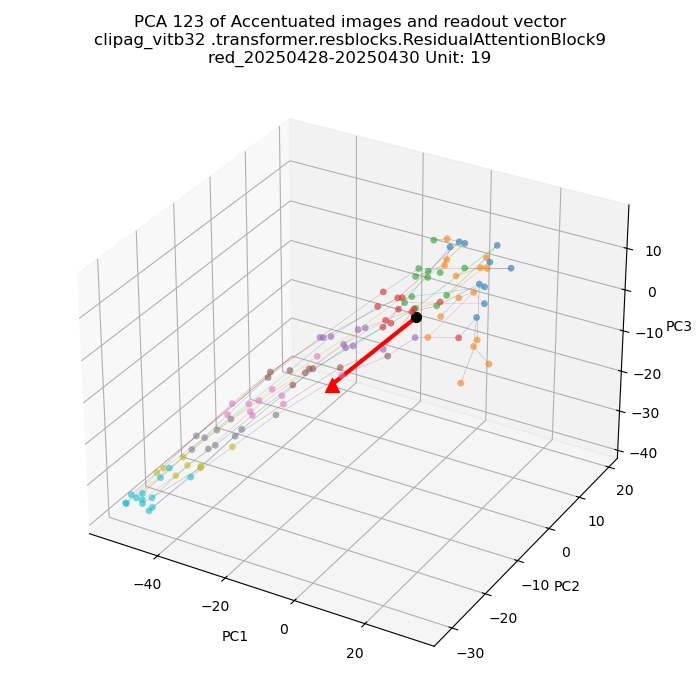

In [ ]:
acc_split_df = cosine_results[1]['df'].reset_index(drop=True)
acc_config = cosine_results[1]["config"]
PCA_resp = cosine_results[1]["PCA_resp"]
readout_vec = cosine_results[1]["readout_vec"]
PC_slice = slice(100, 150)
# three d plot of PCA 123 and readout vector
%matplotlib widget
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
for img_id in acc_split_df.img_id.unique():
    ax.plot(PCA_resp[acc_split_df.img_id == img_id, 0], 
               PCA_resp[acc_split_df.img_id == img_id, 1], 
               PCA_resp[acc_split_df.img_id == img_id, 2], 
               c=f"C{img_id}",
               lw=0.3, alpha=0.6, )
    ax.scatter(PCA_resp[acc_split_df.img_id == img_id, 0], 
               PCA_resp[acc_split_df.img_id == img_id, 1], 
               PCA_resp[acc_split_df.img_id == img_id, 2], 
               c=acc_split_df.score[acc_split_df.img_id == img_id], 
               cmap="tab10", lw=0.3, alpha=0.6, marker="o")
# Plot readout vector as arrow from origin
# ax.quiver(0, 0, 0, readout_vec[0] * 500, readout_vec[1] * 500, readout_vec[2] * 500, 
#           color="red", arrow_length_ratio=0.3, linewidth=3, label="Readout vector")
ax.plot([0, readout_vec[0] * 500], [0, readout_vec[1] * 500], [0, readout_vec[2] * 500], color="red", linewidth=3)
ax.scatter(readout_vec[0] * 500, readout_vec[1] * 500, readout_vec[2] * 500, color="red", s=100, marker="^")
ax.scatter(0, 0, 0, c="black", s=50, marker="o")  # Mark origin
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title(f"PCA 123 of Accentuated images and readout vector\n{acc_config['model_name']} {acc_config['layer_name']}\n{subject_id} Unit: {acc_config['unit_ids'][0]}")
plt.tight_layout()
plt.show()